# Bootcamp Data Science (Sages sp. z o.o.)

## Norbert Tuśnio

### Final project: Statistical effect of air pollution on the formation of various types of cancer

In the project the database of cancers created during the years 1999-2015 was used.<br>
Data source: Wojciechowska Urszula, Didkowska Joanna. Illnesses and deaths from malignant neoplasms in Poland.<br>
National Cancer Registry, Oncology Center - Instytut im. Maria Skłodowska-Curie.<br>
Available at http://onkologia.org.pl/raporty/ (access: August 2018).<br>
The database contains the following diseases in accordance with the ICD-10 classification<br>
(International Statistical Classification of Diseases and Related Health Problems):<br>
<br>
C00-C14 Malignant neoplasms of lip, oral cavity and pharynx<br>
C15-C26 Malignant neoplasms of digestive organs<br>
C30-C39 Malignant neoplasms of respiratory and intrathoracic organs<br>
C40-C41 Malignant neoplasms of bone and articular cartilage<br>
C43-C44 Melanoma and other malignant neoplasms of skin<br>
C45-C49 Malignant neoplasms of mesothelial and soft tissue<br>
C50-C50 Malignant neoplasm of breast<br>
C51-C58 Malignant neoplasms of female genital organs<br>
C60-C63 Malignant neoplasms of male genital organs<br>
C64-C68 Malignant neoplasms of urinary tract<br>
C69-C72 Malignant neoplasms of eye, brain and other parts of central nervous system<br>
C73-C75 Malignant neoplasms of thyroid and other endocrine glands<br>
C76-C80 Malignant neoplasms of ill-defined, secondary and unspecified sites<br>
C81-C96 Malignant neoplasms, stated or presumed to be primary, of lymphoid, haematopoietic and related tissue<br>
C97-C97 Malignant neoplasms of independent (primary) multiple sites<br>
D00-D09 In situ neoplasms<br>
Last series codes have been changed to numbers 100-109.

In [1]:
# Python module import
import base64
import requests
import html2text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

The following function loads cancer statistics from the website onkologia.org.pl for a selected province.<br>
Load method: POST<br>
Available years:  1999-2015<br>
Number of voivodships:   16<br>
Number of sexes:          2<br>
Total possible calls:   544<br>
Principle of operation:<br>
1. Calling the POST method with the parameters "filter" (Base64* coded) and "report"
2. Getting the result in the form of html table
3. Transforming the html table into a text form
4. Separation of individual table lines to the numerical form
5. Summary of the men and women's cases in a given year
6. Expanding the table with information from individual years
7. Returning a Pandas DataFrame with a dimension of 110 rows × 17 columns (rows: disease number, columns: year)<br>
*Base64 is a group of similar binary-to-text encoding schemes that represent binary data in an ASCII string format by translating it into a radix-64 representation. The term Base64 originates from a specific MIME content transfer encoding.

In [2]:
def wczytaj_statystyke_nowotworow(woj):
    url='http://onkologia.org.pl/raporty_online/tabela_nowotwor_wsur_wiek.php'    
    df=pd.DataFrame()
    for rok in range(1999,2016):
        for plec in ['M','K']:
            tekst=str(woj*2)
            if len(tekst)==1:
                tekst='0'+tekst
            tekst='wojewodztwo='+tekst+'&rok%5B%5D='+str(rok)+'&plec='+plec+'&rodzaj=zachorowania'
            filtr=base64.encodebytes(bytes(tekst,'utf-8'))
            payload = {'filtr': filtr,
                      'raport': 'tabela_nowotwor_wsur_wiek'
                      }
            r=requests.post(url,data=payload)
            r=html2text.html2text(r.text)
            r=r.splitlines()
            r=r[8:-1]
            x=[]
            for i in r:
                if i[0]=='C' or i[0]=='D':
                    x.append(i)
                else:
                    x[-1]+=i
            r=x
            s=[0]*110
            for i in r:
                x=i.split('|')
                nr=int(x[0][1:])
                if x[0][0]=='D':
                    nr+=100
                s[nr]=float(x[19])
            if plec=='M':
                dfm=pd.Series(s)
            else:
                dfk=pd.Series(s)
        ss=pd.DataFrame((dfm+dfk)/2,columns=[rok])
        df=pd.concat([df,ss],axis=1)
    return df

The second function reads the gas concentration data from the page powietrze.gios.gov.pl/pjp/archives<br>
Load method:     read_excel<br>
Available years:  2000-2016<br>
Number of voivodships:   17<br>
Number of gases:         13<br>
Measuring stations:     264<br>
Principle of operation:<br>
1. The process of transforming the voivodeship number into the full name
2. Loading statistical data from the excel file (3 columns: year, province, average measurement)
3. Cutting data only for one province
4. Data grouping due to the year and calculation of the average of all measurements
5. Selecting data for comparison (correlation)
 - xx - a list containing years in which data on both cancer and air pollution statistics are available
 - y1 - a list containing statistical data on the formation of tumors in subsequent years
 - y2 - a list containing statistical data on air pollution for a given gas
6. Calculation of Pearson's correlation and its best result
7. Determining what type of cancer is most correlated with a given type of air pollution
8. Drawing a line graph<br>
*Pearson correlation coefficient (PCC), also referred to as Pearson's r, the Pearson product-moment correlation coefficient (PPMCC) or the bivariate correlation, is a measure of the linear correlation between two variables X and Y. It has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

In [3]:
def wczytaj_zanieczyszczenia(woj,gaz,icd,wykresy):  
    
    if woj==1: woj='dolnośląskie'
    if woj==2: woj='kujawsko-pomorskie'
    if woj==3: woj='lubelskie'
    if woj==4: woj='lubuskie'
    if woj==5: woj='łódzkie'
    if woj==6: woj='małopolskie'
    if woj==7: woj='mazowieckie'
    if woj==8: woj='opolskie'
    if woj==9: woj='podkarpackie'
    if woj==10: woj='podlaskie'
    if woj==11: woj='pomorskie'
    if woj==12: woj='śląskie'
    if woj==13: woj='świętokrzyskie'
    if woj==14: woj='warmińsko-mazurskie'
    if woj==15: woj='wielkopolskie'
    if woj==16: woj='zachodniopomorskie'

    r=pd.read_excel('Statystyki_2000-2016_wer20170831.xlsx',sheet_name=gaz,usecols='A,B,I')
    r=r[r.Województwo==woj]
    r=r.groupby('Rok').mean()
    r=r[:-1]

    if wykresy:
        rok_od=r.index.min()
        lata=list(r.index)
        ile=len(lata)
        maxx=-1
        summ=0
        if icd==110:
            icd_od=0
            icd_do=110
        else:
            icd_od=icd
            icd_do=icd+1
        for rak in range(icd_od,icd_do):
            xx=[0]*ile
            y1=[0]*ile
            y2=[0]*ile
            i=0
            for rok in lata:
                xx[i]=rok
                y1[i]=df.iat[rak,rok-1999]
                y2[i]=r.iat[i,0]
                i+=1
            korelacja=np.corrcoef(y1,y2)[0,1]
            if ~np.isnan(korelacja):
                summ+=korelacja
            if korelacja>maxx:
                maxx=korelacja
                ktory=rak
                y1best=y1
                y2best=y2

        host=host_subplot(111)
        par=host.twinx()
        host.set_xlabel("Year")
        host.set_ylabel("Average annual measurement of pollution")
        par.set_ylabel("Cancer incidence rate")
        p1,=host.plot(xx,y2best,label="Pollution")
        p2,=par.plot(xx,y1best,label="Cancer")
        leg=plt.legend()
        host.yaxis.get_label().set_color(p1.get_color())
        leg.texts[0].set_color(p1.get_color())
        par.yaxis.get_label().set_color(p2.get_color())
        leg.texts[1].set_color(p2.get_color())
        plt.show()
    
        if ktory<10:
            ktory='C0'+str(ktory)
        else:
            if ktory<100:
                ktory='C'+str(ktory)
            else:
                ktory='D0'+str(ktory-100)
        print(woj,gaz,'ICD='+ktory,'PCC={:5.3f}'.format(maxx),summ)
        
    return r

C:\Users\Python\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Python\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


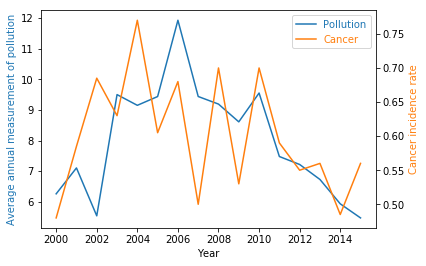

dolnośląskie SO2 ICD=C11 PCC=0.462 -10.4188262716


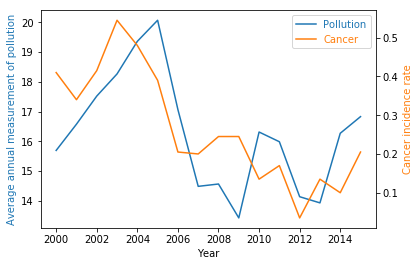

dolnośląskie NO2 ICD=C96 PCC=0.654 -16.1284241121


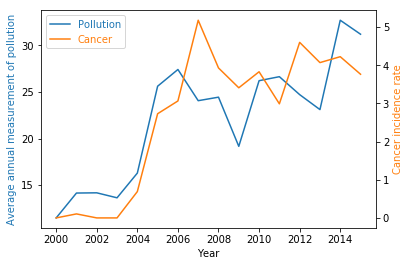

dolnośląskie NOx ICD=C83 PCC=0.833 22.8010571579


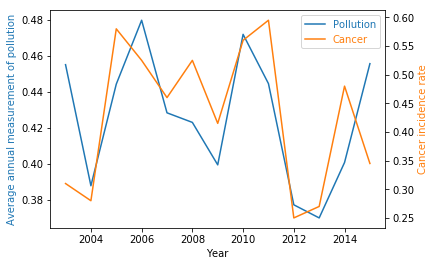

dolnośląskie CO ICD=C40 PCC=0.608 -6.97206883709


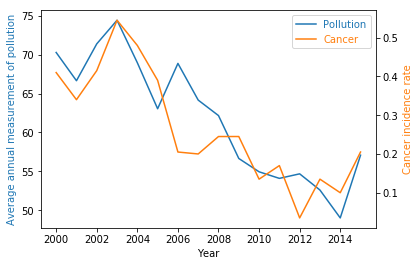

dolnośląskie O3 ICD=C96 PCC=0.852 -23.4526015014


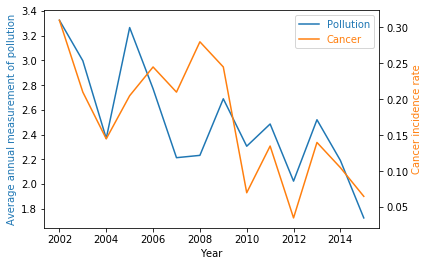

dolnośląskie C6H6 ICD=C75 PCC=0.677 -24.6048090501


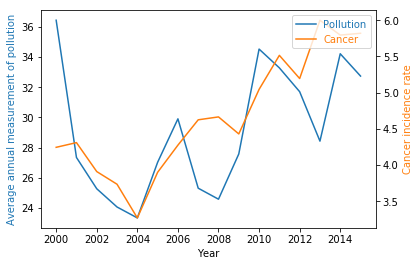

dolnośląskie PM10 ICD=C22 PCC=0.601 8.26819466395


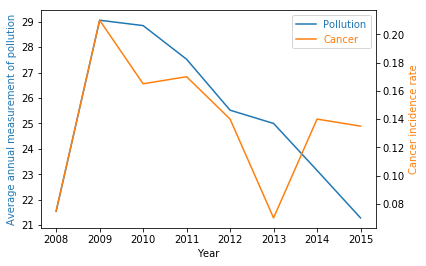

dolnośląskie PM2,5 ICD=C37 PCC=0.691 -22.1142273653


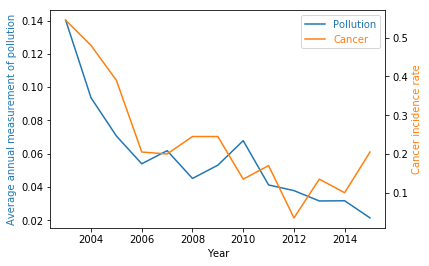

dolnośląskie Pb(PM10) ICD=C96 PCC=0.843 -24.0826022899


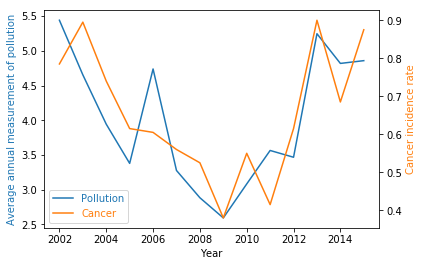

dolnośląskie As(PM10) ICD=C07 PCC=0.814 -0.245887038803


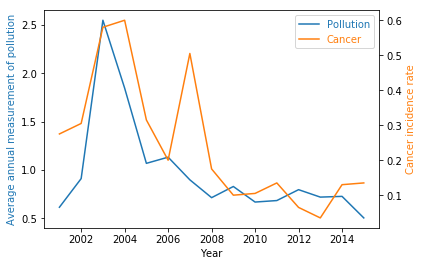

dolnośląskie Cd(PM10) ICD=C70 PCC=0.778 -17.2818031234


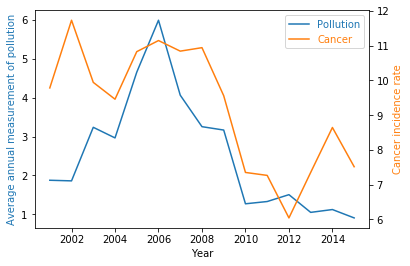

dolnośląskie Ni(PM10) ICD=C80 PCC=0.720 -15.2031033816


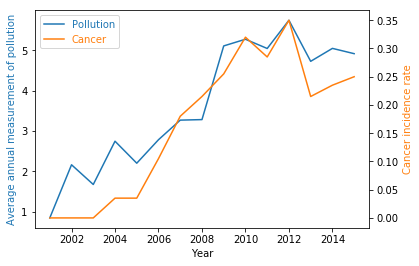

dolnośląskie BaP(PM10) ICD=D02 PCC=0.948 21.2826741762


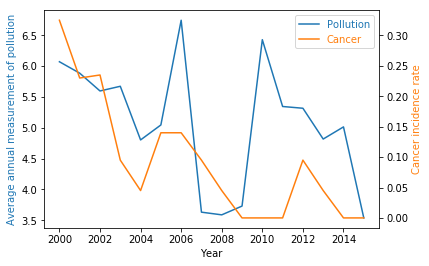

kujawsko-pomorskie SO2 ICD=C55 PCC=0.469 -19.4773483482


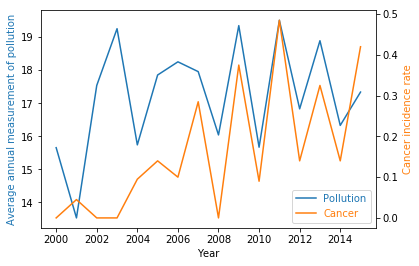

kujawsko-pomorskie NO2 ICD=D07 PCC=0.554 10.7799671166


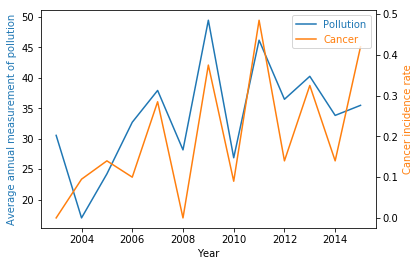

kujawsko-pomorskie NOx ICD=D07 PCC=0.746 24.5651668925


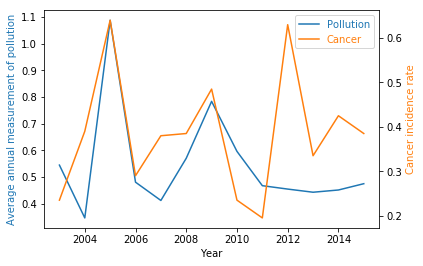

kujawsko-pomorskie CO ICD=C40 PCC=0.478 -9.63428628558


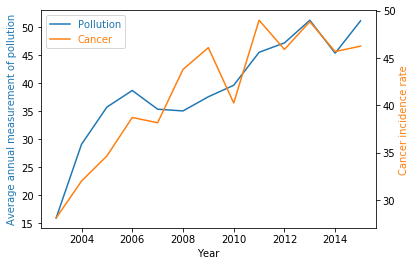

kujawsko-pomorskie O3 ICD=C50 PCC=0.882 36.6701731254


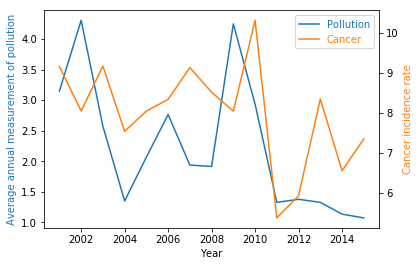

kujawsko-pomorskie C6H6 ICD=C53 PCC=0.488 -21.2150153505


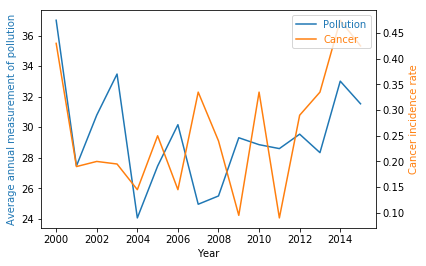

kujawsko-pomorskie PM10 ICD=C30 PCC=0.421 -2.36489122011


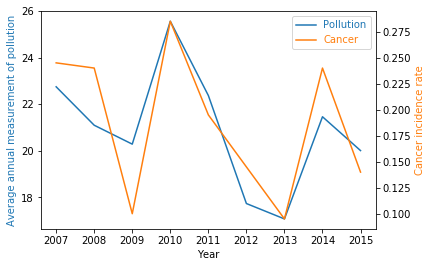

kujawsko-pomorskie PM2,5 ICD=C88 PCC=0.832 -12.9553777734


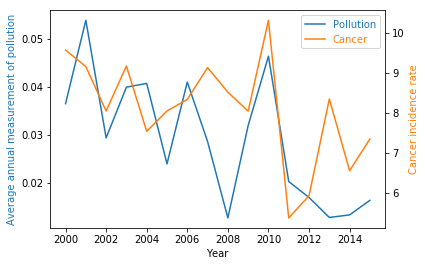

kujawsko-pomorskie Pb(PM10) ICD=C53 PCC=0.604 -28.4180962257


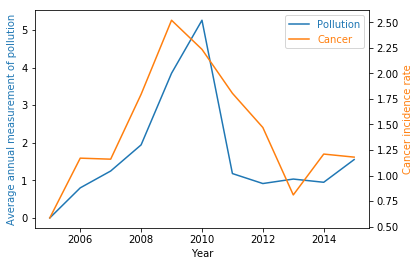

kujawsko-pomorskie As(PM10) ICD=C78 PCC=0.835 6.61332373179


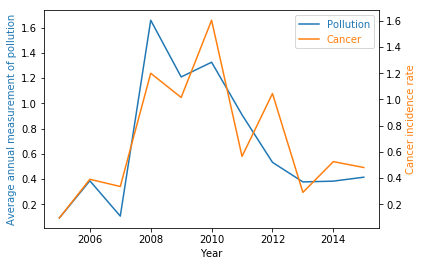

kujawsko-pomorskie Cd(PM10) ICD=C96 PCC=0.845 4.6176711769


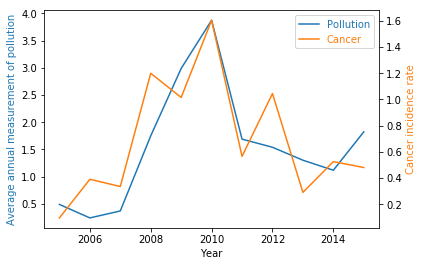

kujawsko-pomorskie Ni(PM10) ICD=C96 PCC=0.831 12.6939870843


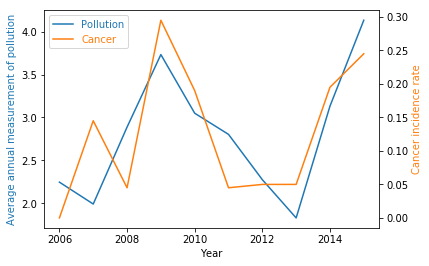

kujawsko-pomorskie BaP(PM10) ICD=C68 PCC=0.758 11.041247573


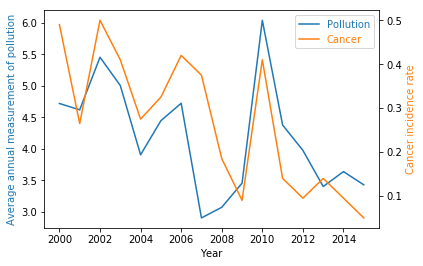

lubelskie SO2 ICD=C95 PCC=0.657 -4.11577673492


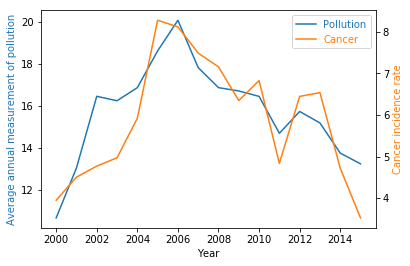

lubelskie NO2 ICD=C91 PCC=0.853 6.4483297022


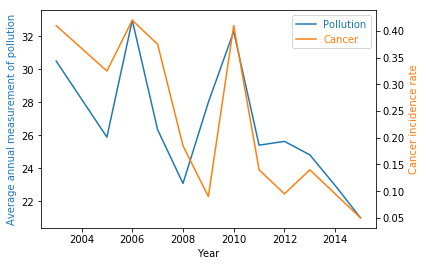

lubelskie NOx ICD=C95 PCC=0.778 -8.51564780517


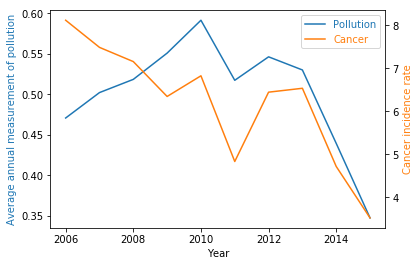

lubelskie CO ICD=C91 PCC=0.600 -10.1537145626


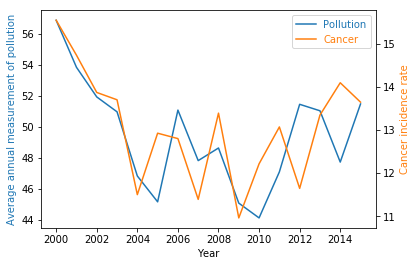

lubelskie O3 ICD=C16 PCC=0.700 -6.26076128673


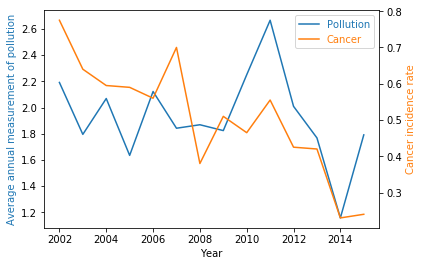

lubelskie C6H6 ICD=C40 PCC=0.452 -7.19206053013


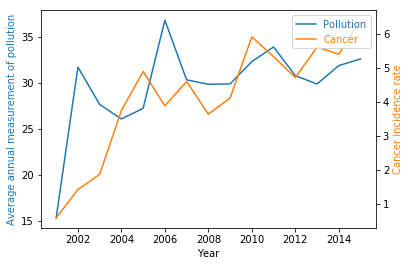

lubelskie PM10 ICD=C83 PCC=0.596 6.53518227799


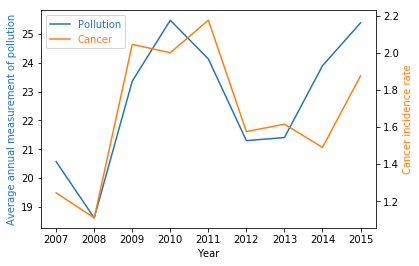

lubelskie PM2,5 ICD=C79 PCC=0.817 0.910799367433


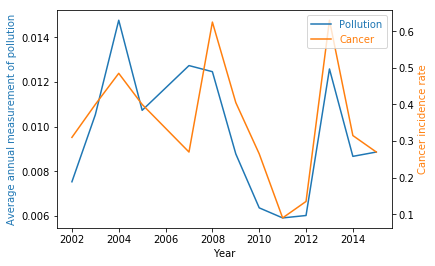

lubelskie Pb(PM10) ICD=C57 PCC=0.768 -3.89092582484


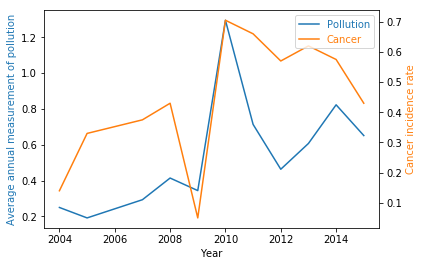

lubelskie As(PM10) ICD=C01 PCC=0.736 3.58830922224


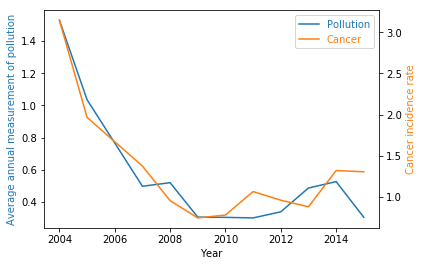

lubelskie Cd(PM10) ICD=C85 PCC=0.946 -3.7236559587


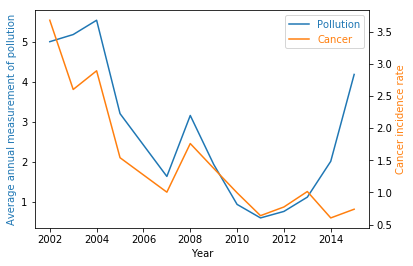

lubelskie Ni(PM10) ICD=C76 PCC=0.808 -6.8550673681


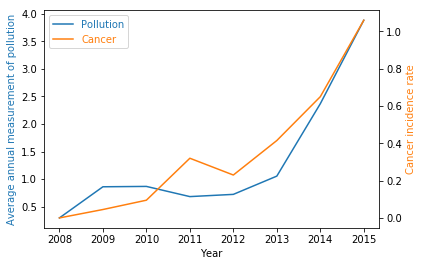

lubelskie BaP(PM10) ICD=D03 PCC=0.945 8.57997669299


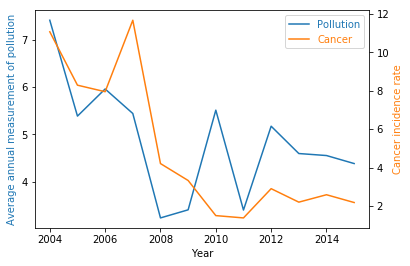

lubuskie SO2 ICD=C80 PCC=0.663 -23.2569546741


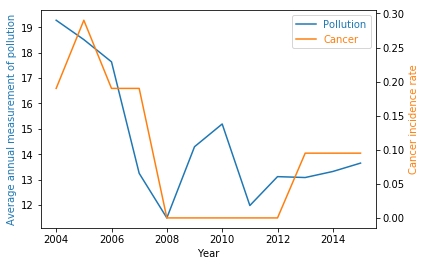

lubuskie NO2 ICD=C57 PCC=0.718 -27.3733753167


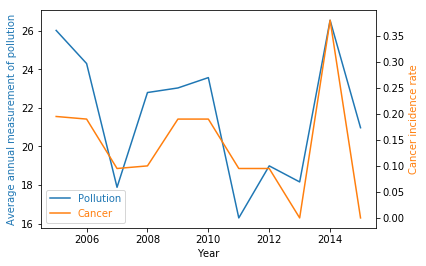

lubuskie NOx ICD=D07 PCC=0.750 -4.2456971593


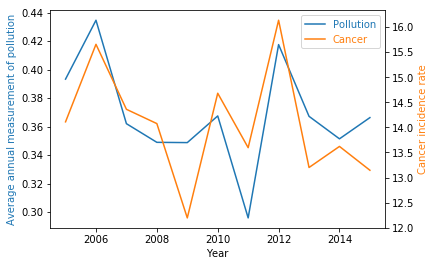

lubuskie CO ICD=C16 PCC=0.683 -8.96220784094


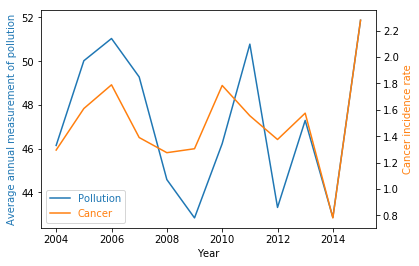

lubuskie O3 ICD=C49 PCC=0.744 -8.30399359166


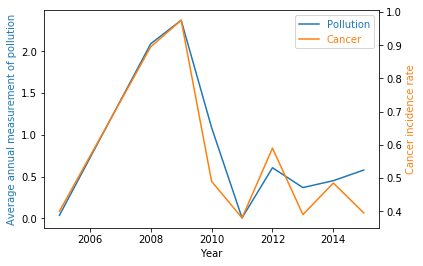

lubuskie C6H6 ICD=C69 PCC=0.947 0.489828676494


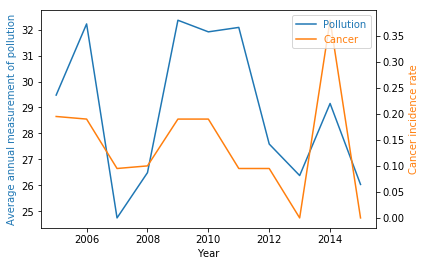

lubuskie PM10 ICD=D07 PCC=0.500 -11.4601108655


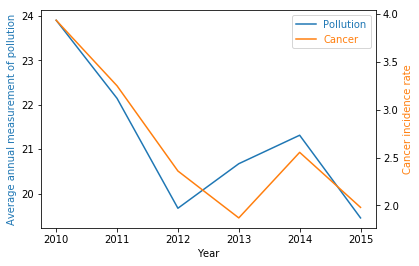

lubuskie PM2,5 ICD=C79 PCC=0.914 -16.8629781602


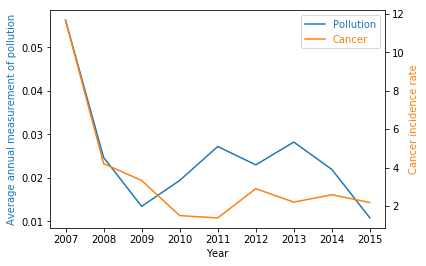

lubuskie Pb(PM10) ICD=C80 PCC=0.850 -12.3829197908


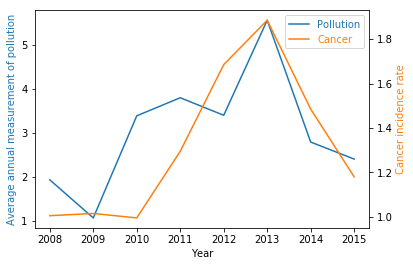

lubuskie As(PM10) ICD=C04 PCC=0.759 0.442959677844


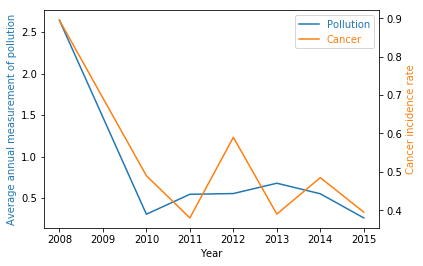

lubuskie Cd(PM10) ICD=C69 PCC=0.898 -8.16192679977


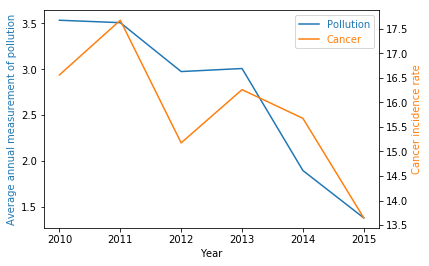

lubuskie Ni(PM10) ICD=C20 PCC=0.837 -23.0692998533


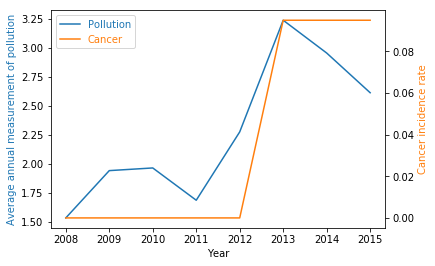

lubuskie BaP(PM10) ICD=C57 PCC=0.895 16.8148704683


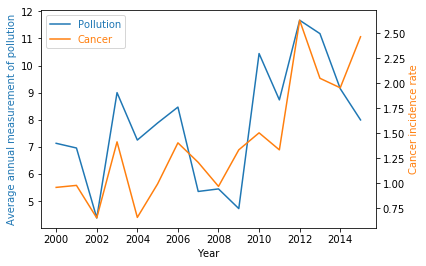

łódzkie SO2 ICD=C24 PCC=0.688 24.2178807283


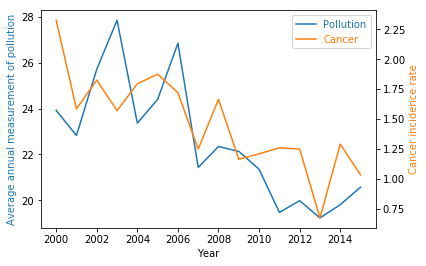

łódzkie NO2 ICD=C00 PCC=0.682 -32.6946666817


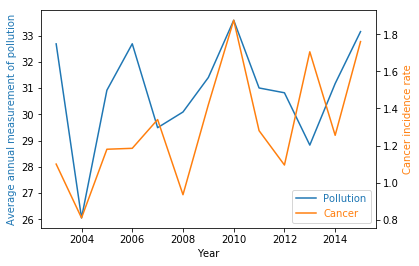

łódzkie NOx ICD=C51 PCC=0.499 7.06926876811


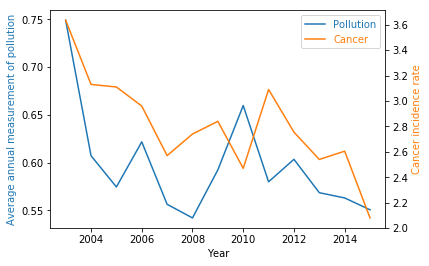

łódzkie CO ICD=C23 PCC=0.621 -21.9091011071


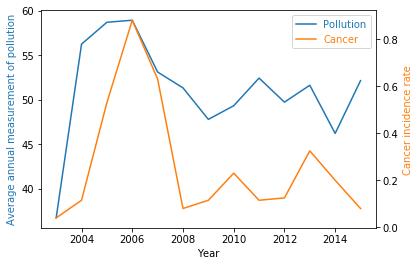

łódzkie O3 ICD=D04 PCC=0.599 2.24605124235


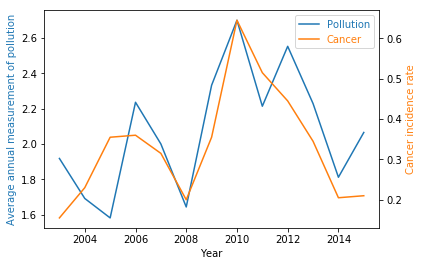

łódzkie C6H6 ICD=C45 PCC=0.749 12.7582917106


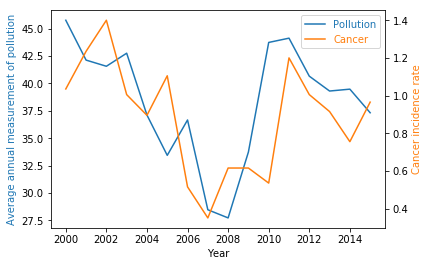

łódzkie PM10 ICD=C38 PCC=0.573 -6.16088913962


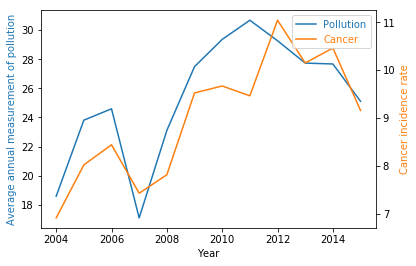

łódzkie PM2,5 ICD=C25 PCC=0.871 23.7618511119


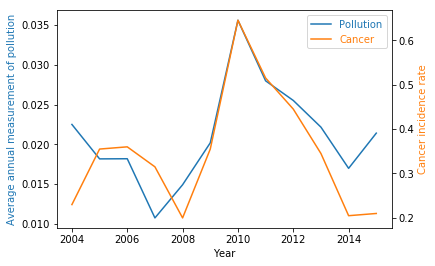

łódzkie Pb(PM10) ICD=C45 PCC=0.773 8.74191656109


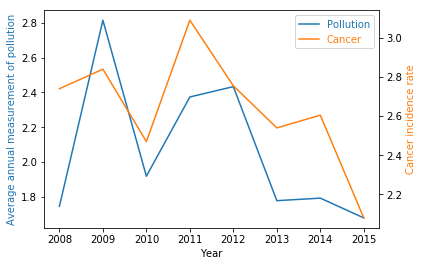

łódzkie As(PM10) ICD=C23 PCC=0.665 -14.0207542978


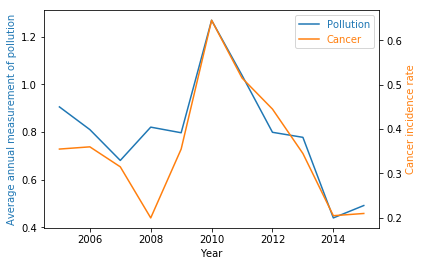

łódzkie Cd(PM10) ICD=C45 PCC=0.874 -17.8728543574


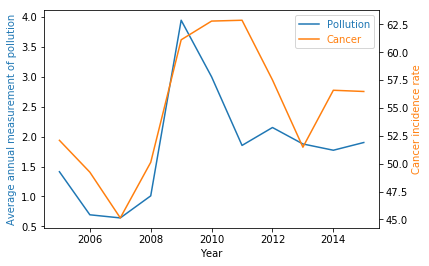

łódzkie Ni(PM10) ICD=C34 PCC=0.808 13.1572264359


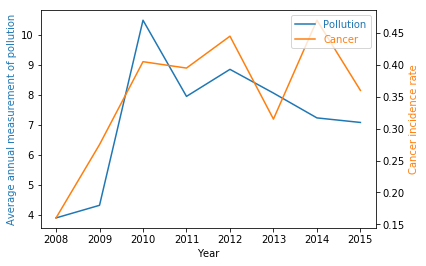

łódzkie BaP(PM10) ICD=C65 PCC=0.761 13.7107264093


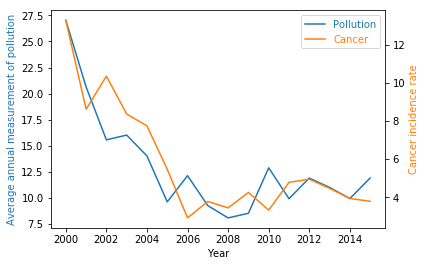

małopolskie SO2 ICD=C80 PCC=0.872 -6.31594711273


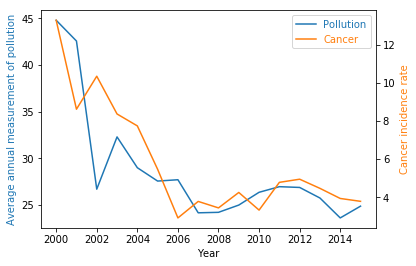

małopolskie NO2 ICD=C80 PCC=0.786 -9.77076077542


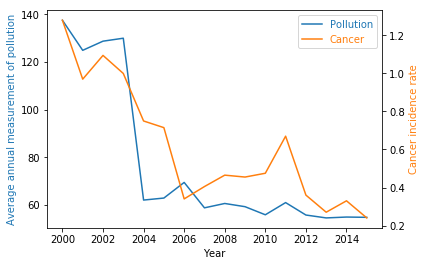

małopolskie NOx ICD=C38 PCC=0.898 -8.03698435709


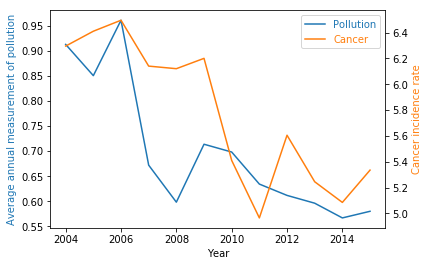

małopolskie CO ICD=C32 PCC=0.752 -11.3038686717


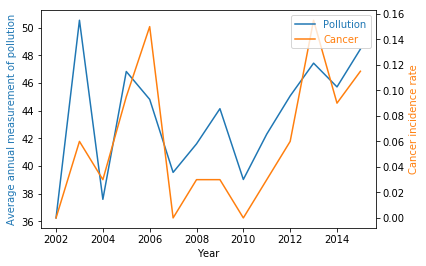

małopolskie O3 ICD=C93 PCC=0.724 9.42943634708


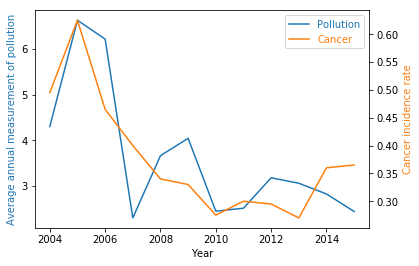

małopolskie C6H6 ICD=C40 PCC=0.789 -10.0073964758


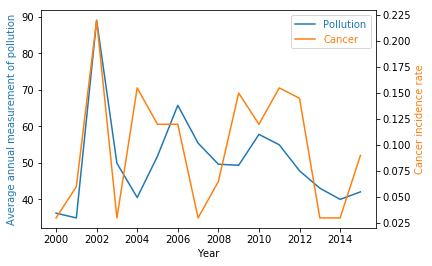

małopolskie PM10 ICD=C37 PCC=0.619 -4.10601738039


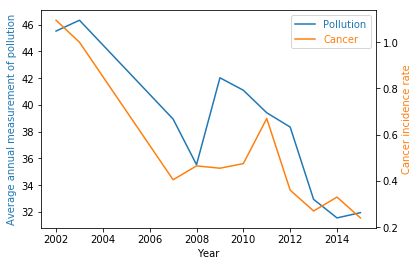

małopolskie PM2,5 ICD=C38 PCC=0.843 -10.0235494197


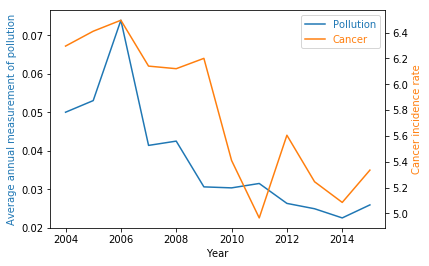

małopolskie Pb(PM10) ICD=C32 PCC=0.800 -13.396233524


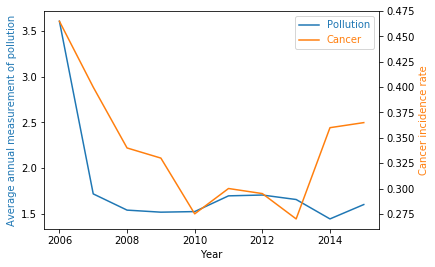

małopolskie As(PM10) ICD=C40 PCC=0.709 -6.37939652815


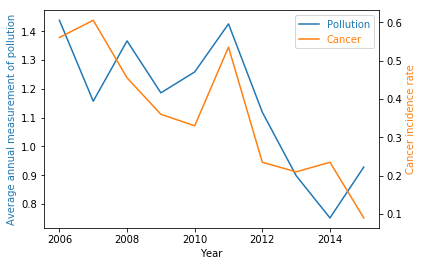

małopolskie Cd(PM10) ICD=C74 PCC=0.762 -15.5443219622


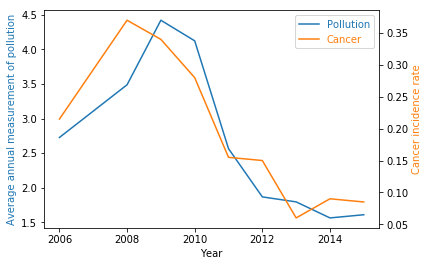

małopolskie Ni(PM10) ICD=C47 PCC=0.912 -18.5450652724


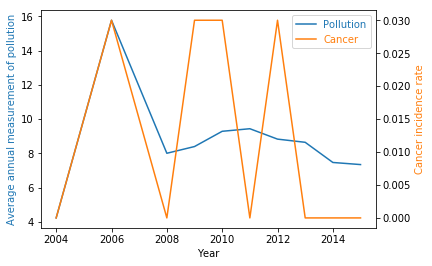

małopolskie BaP(PM10) ICD=C58 PCC=0.546 -9.84324814931


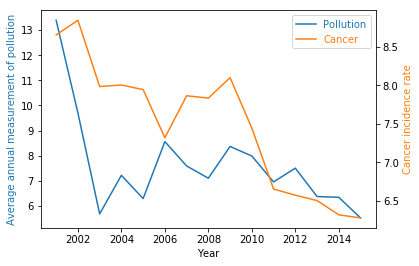

mazowieckie SO2 ICD=C53 PCC=0.600 -9.05185369444


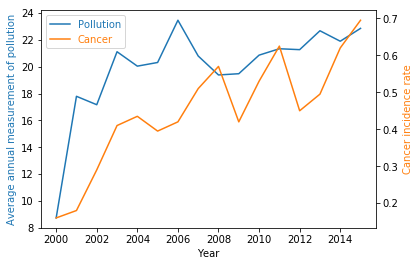

mazowieckie NO2 ICD=C17 PCC=0.724 12.9285389515


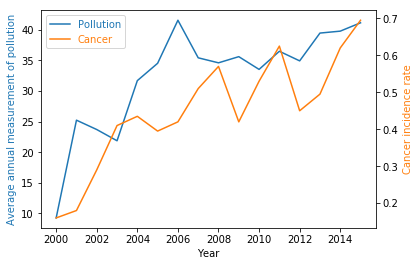

mazowieckie NOx ICD=C17 PCC=0.781 12.556233479


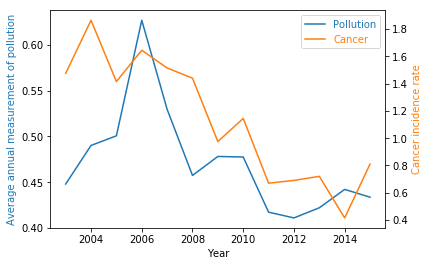

mazowieckie CO ICD=C10 PCC=0.681 -11.5526111615


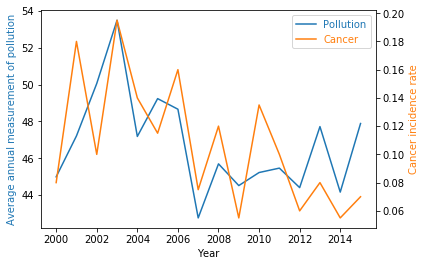

mazowieckie O3 ICD=C33 PCC=0.643 -5.14926228116


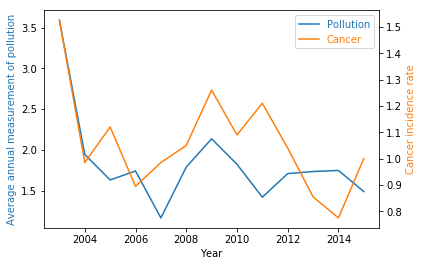

mazowieckie C6H6 ICD=C00 PCC=0.692 -2.42352140001


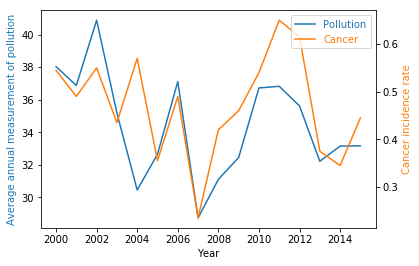

mazowieckie PM10 ICD=C38 PCC=0.638 -6.00521338677


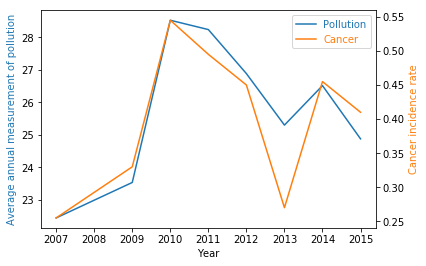

mazowieckie PM2,5 ICD=C03 PCC=0.889 3.41674490221


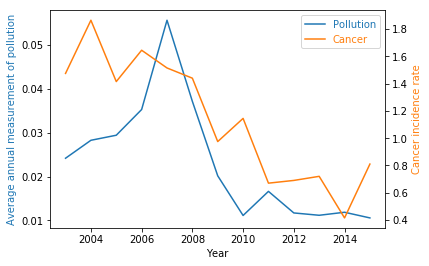

mazowieckie Pb(PM10) ICD=C10 PCC=0.735 -10.6994769731


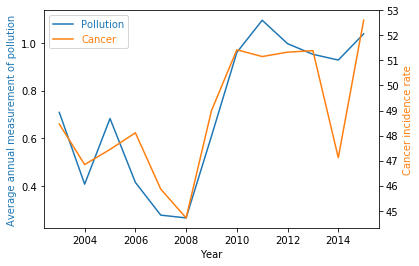

mazowieckie As(PM10) ICD=C34 PCC=0.858 12.5490644725


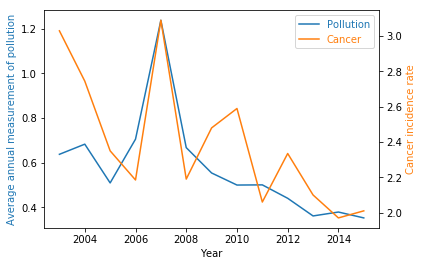

mazowieckie Cd(PM10) ICD=C23 PCC=0.714 -6.92492685583


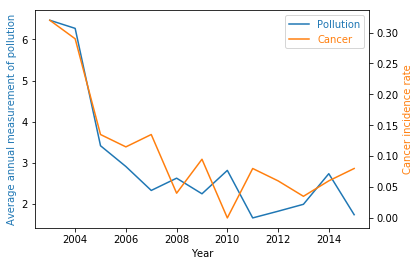

mazowieckie Ni(PM10) ICD=C94 PCC=0.888 -9.71879367369


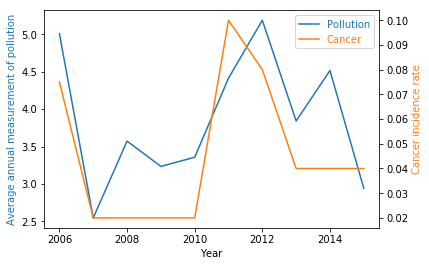

mazowieckie BaP(PM10) ICD=C39 PCC=0.772 -3.7350862511


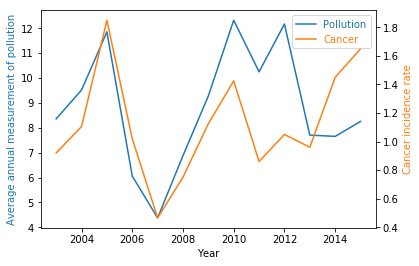

opolskie SO2 ICD=C51 PCC=0.561 4.05155356591


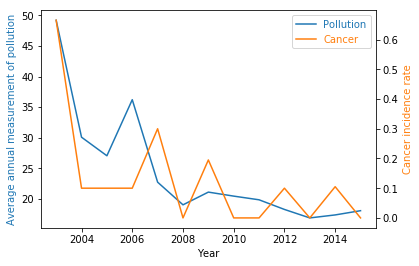

opolskie NO2 ICD=C14 PCC=0.777 -19.2228911178


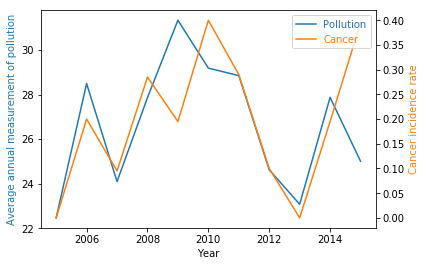

opolskie NOx ICD=C26 PCC=0.617 2.42339519474


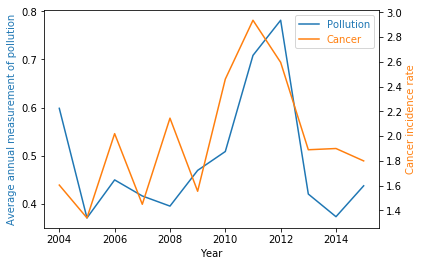

opolskie CO ICD=C49 PCC=0.682 2.41836356407


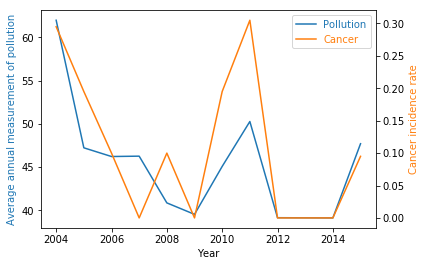

opolskie O3 ICD=C72 PCC=0.784 -18.8204567805


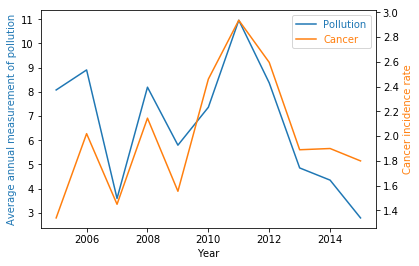

opolskie C6H6 ICD=C49 PCC=0.630 -11.6728588467


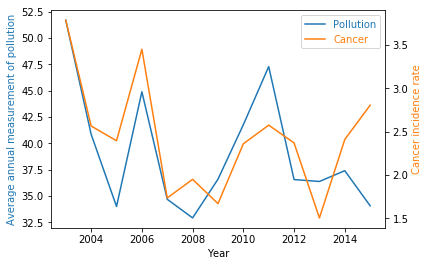

opolskie PM10 ICD=C80 PCC=0.725 -7.2586604655


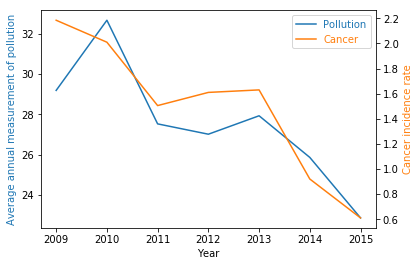

opolskie PM2,5 ICD=C10 PCC=0.878 -11.4558726039


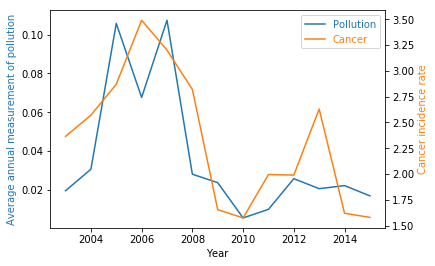

opolskie Pb(PM10) ICD=C79 PCC=0.725 -18.6362903468


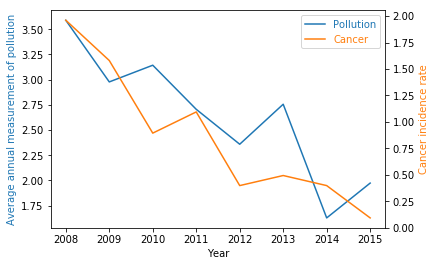

opolskie As(PM10) ICD=C77 PCC=0.827 -20.1712780505


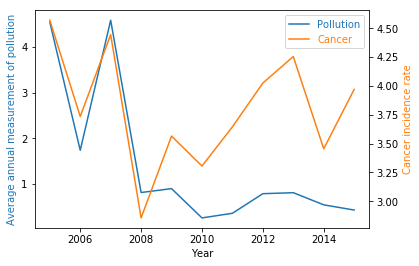

opolskie Cd(PM10) ICD=C15 PCC=0.680 -21.4770977186


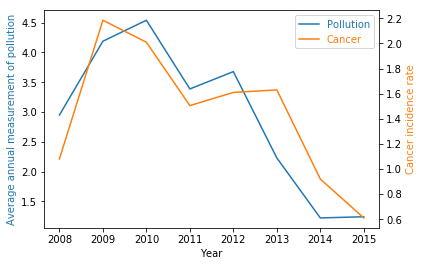

opolskie Ni(PM10) ICD=C10 PCC=0.871 -15.102657453


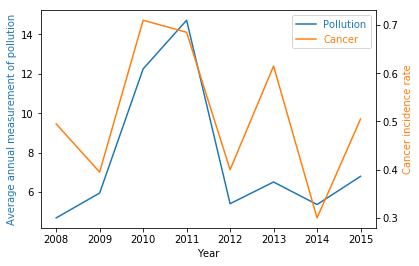

opolskie BaP(PM10) ICD=C45 PCC=0.793 -8.90152830466


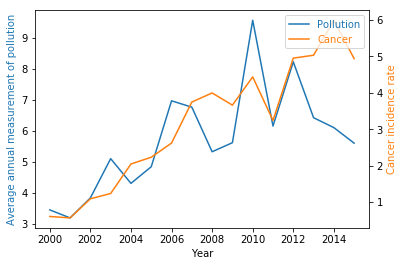

podkarpackie SO2 ICD=C83 PCC=0.710 18.5466697947


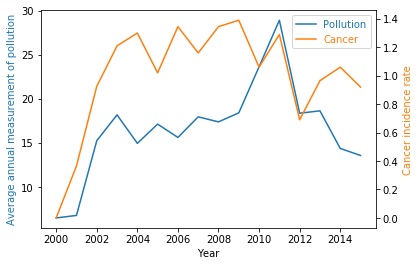

podkarpackie NO2 ICD=D06 PCC=0.674 8.81545344542


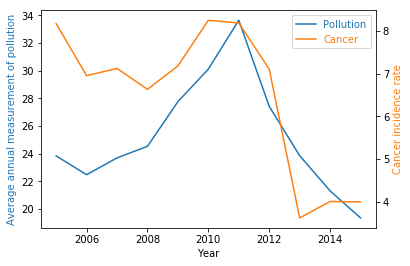

podkarpackie NOx ICD=C80 PCC=0.685 -19.9182878456


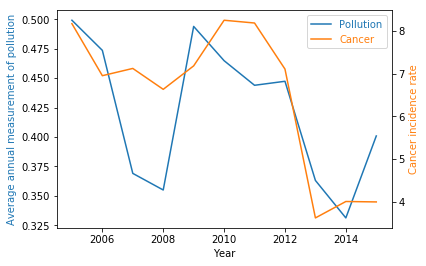

podkarpackie CO ICD=C80 PCC=0.695 -21.1568817189


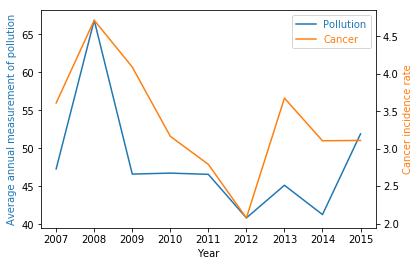

podkarpackie O3 ICD=C22 PCC=0.726 -11.2746108514


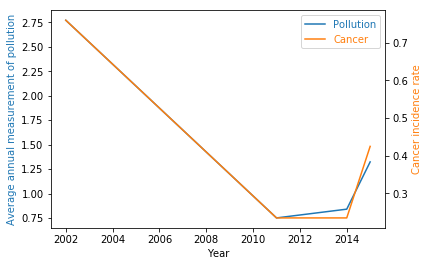

podkarpackie C6H6 ICD=C38 PCC=0.994 -29.7470516909


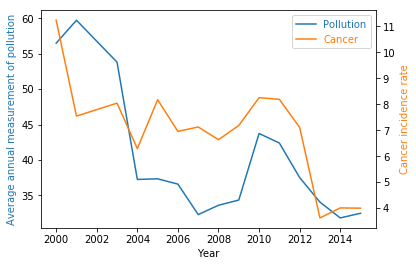

podkarpackie PM10 ICD=C80 PCC=0.667 -27.1464415692


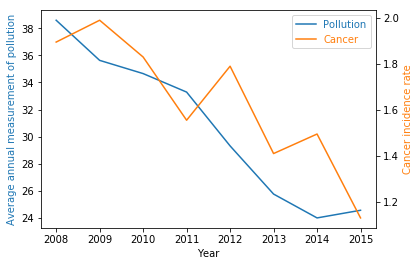

podkarpackie PM2,5 ICD=C24 PCC=0.822 -33.4469274053


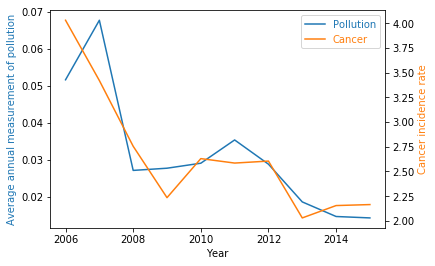

podkarpackie Pb(PM10) ICD=C85 PCC=0.859 -22.103989003


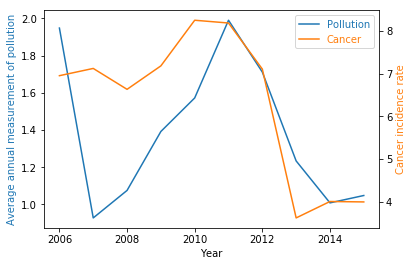

podkarpackie As(PM10) ICD=C80 PCC=0.593 -20.8057375382


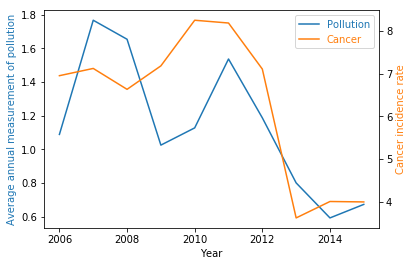

podkarpackie Cd(PM10) ICD=C80 PCC=0.714 -27.1999622914


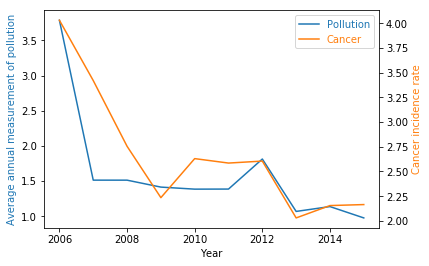

podkarpackie Ni(PM10) ICD=C85 PCC=0.853 -17.3807431395


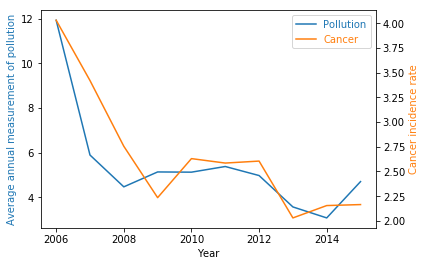

podkarpackie BaP(PM10) ICD=C85 PCC=0.876 -19.2095260221


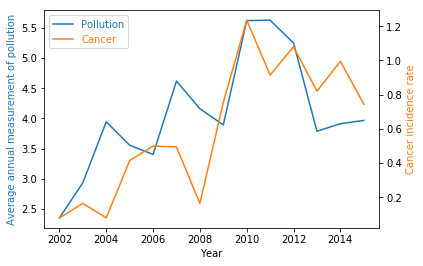

podlaskie SO2 ICD=C70 PCC=0.711 -6.11072945778


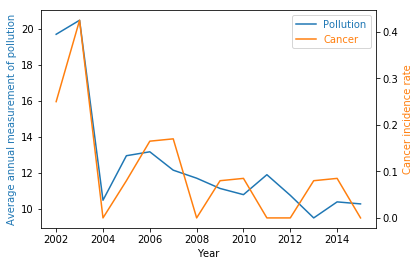

podlaskie NO2 ICD=C33 PCC=0.865 -2.21351952873


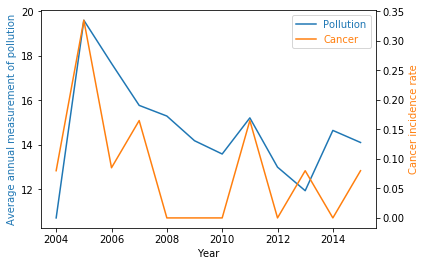

podlaskie NOx ICD=C88 PCC=0.614 -3.53555667006


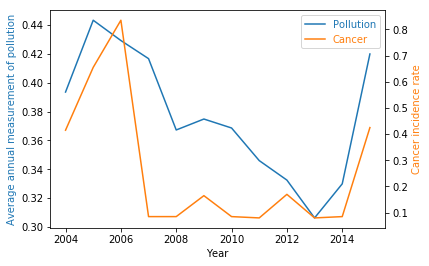

podlaskie CO ICD=C95 PCC=0.741 -1.99239403083


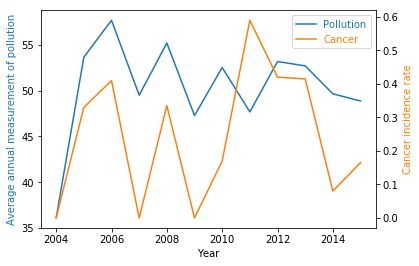

podlaskie O3 ICD=C06 PCC=0.533 -2.33500819459


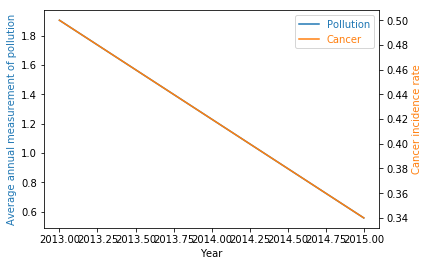

podlaskie C6H6 ICD=C05 PCC=1.000 -10.0


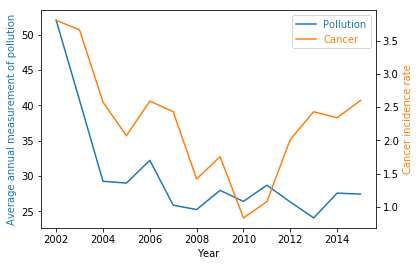

podlaskie PM10 ICD=C85 PCC=0.728 2.92095517507


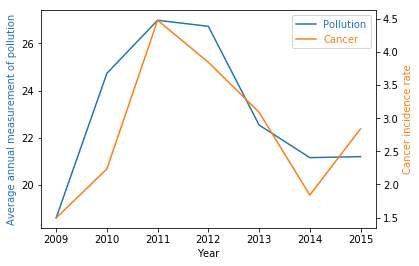

podlaskie PM2,5 ICD=C90 PCC=0.836 -1.8634791047


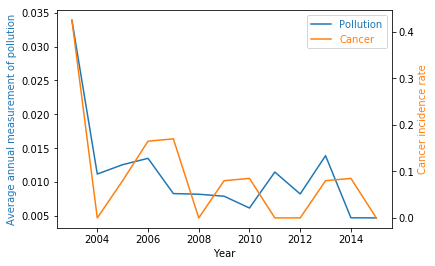

podlaskie Pb(PM10) ICD=C33 PCC=0.823 0.985343849836


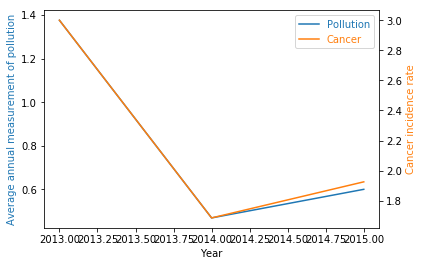

podlaskie As(PM10) ICD=C78 PCC=0.999 -3.01803980306


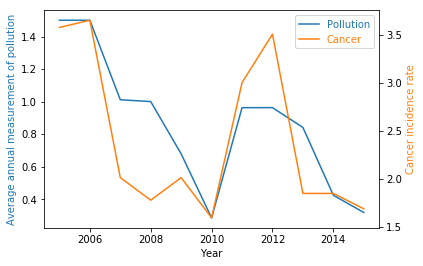

podlaskie Cd(PM10) ICD=C92 PCC=0.792 -3.88388021911


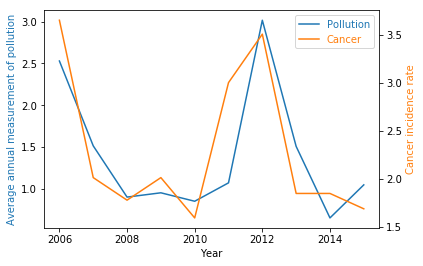

podlaskie Ni(PM10) ICD=C92 PCC=0.821 9.42012919795


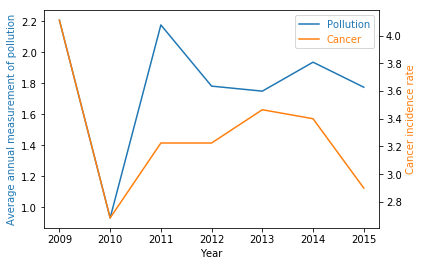

podlaskie BaP(PM10) ICD=C15 PCC=0.734 2.64056084814


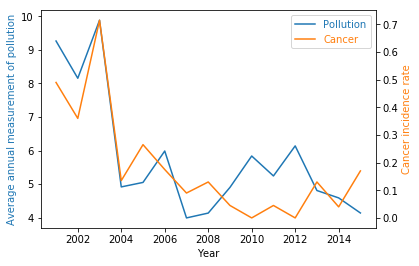

pomorskie SO2 ICD=C55 PCC=0.824 -3.49209271328


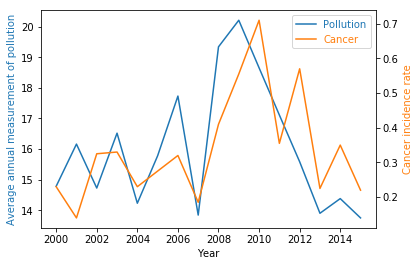

pomorskie NO2 ICD=C31 PCC=0.659 -7.05715731605


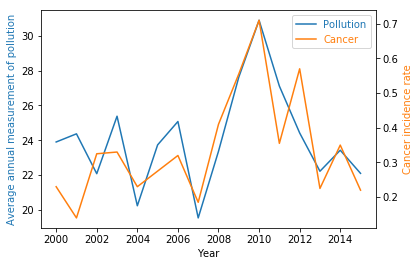

pomorskie NOx ICD=C31 PCC=0.748 2.57548888799


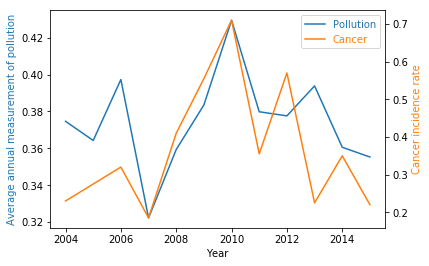

pomorskie CO ICD=C31 PCC=0.628 4.36082636196


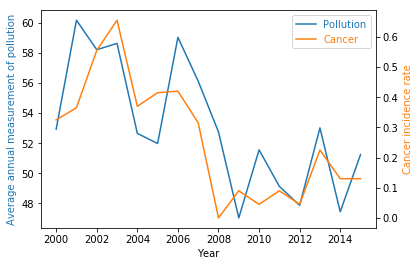

pomorskie O3 ICD=C95 PCC=0.765 -12.0089524336


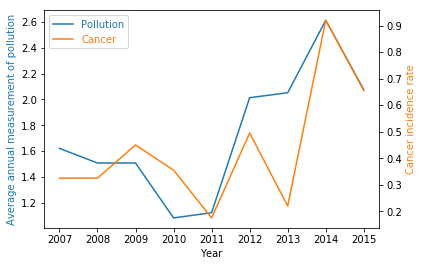

pomorskie C6H6 ICD=C66 PCC=0.751 17.7251755175


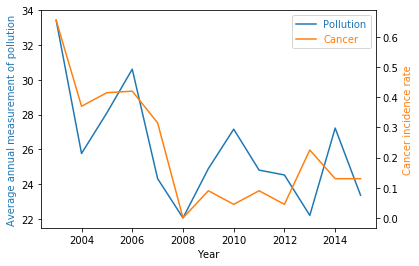

pomorskie PM10 ICD=C95 PCC=0.743 -8.31653190637


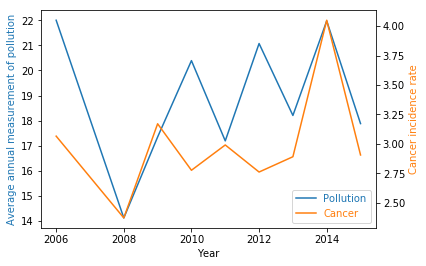

pomorskie PM2,5 ICD=C92 PCC=0.573 8.90436012522


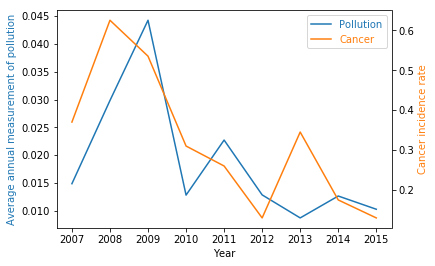

pomorskie Pb(PM10) ICD=C48 PCC=0.736 -13.3145448883


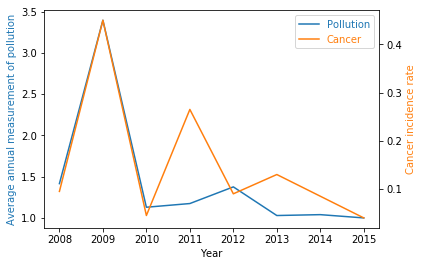

pomorskie As(PM10) ICD=C77 PCC=0.858 -3.45849974826


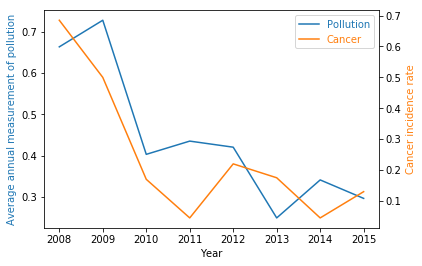

pomorskie Cd(PM10) ICD=C76 PCC=0.834 -21.7940492527


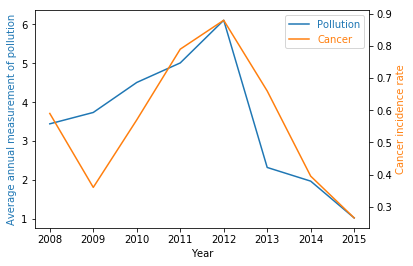

pomorskie Ni(PM10) ICD=C26 PCC=0.793 -9.40733878058


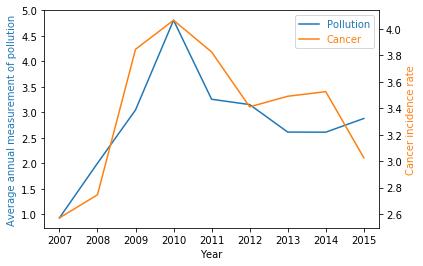

pomorskie BaP(PM10) ICD=C62 PCC=0.856 8.93503140375


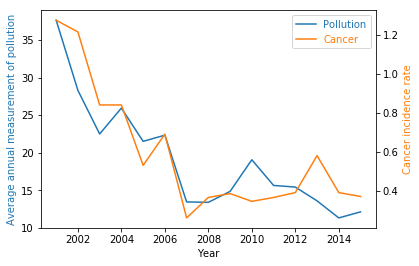

śląskie SO2 ICD=C48 PCC=0.909 -27.0240024426


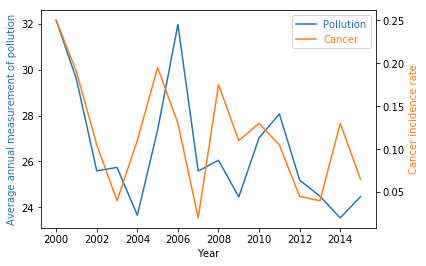

śląskie NO2 ICD=C33 PCC=0.611 -12.2600530022


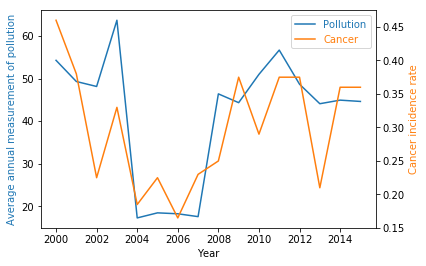

śląskie NOx ICD=C57 PCC=0.699 11.6075513611


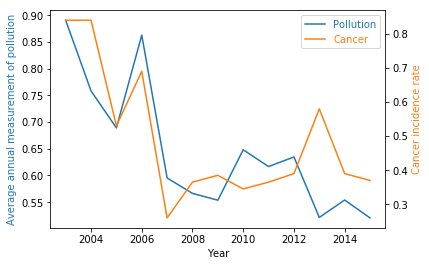

śląskie CO ICD=C48 PCC=0.774 -17.2727509952


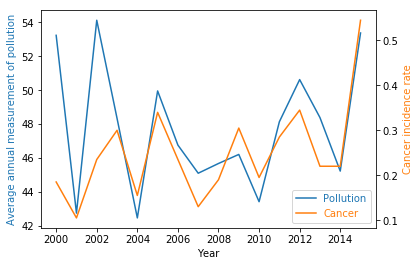

śląskie O3 ICD=C30 PCC=0.609 6.84055108482


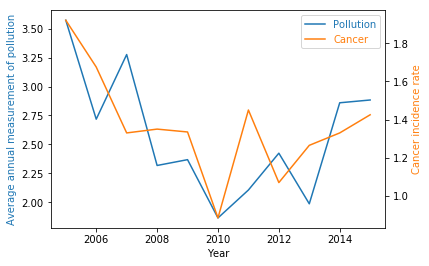

śląskie C6H6 ICD=C85 PCC=0.679 -15.1071652797


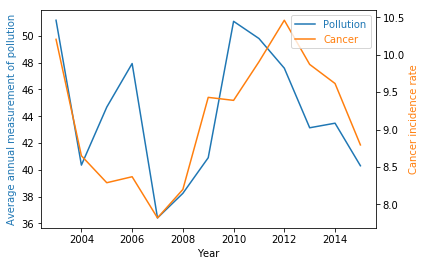

śląskie PM10 ICD=C25 PCC=0.630 5.92776887013


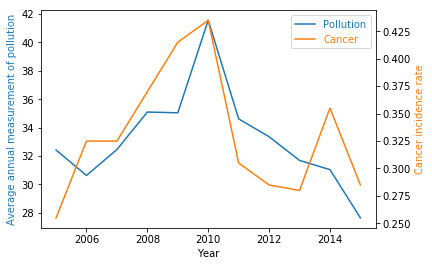

śląskie PM2,5 ICD=C31 PCC=0.694 -9.2876385042


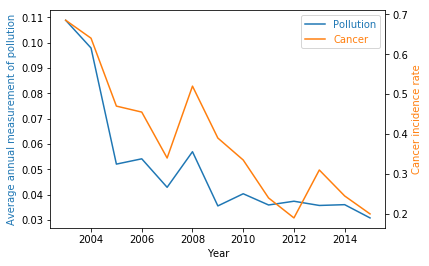

śląskie Pb(PM10) ICD=C40 PCC=0.908 -15.7105660023


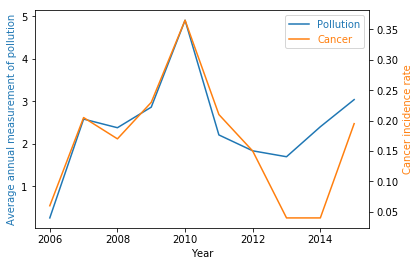

śląskie As(PM10) ICD=C70 PCC=0.819 4.81040787735


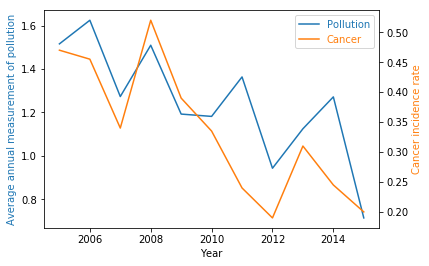

śląskie Cd(PM10) ICD=C40 PCC=0.784 -27.7279591835


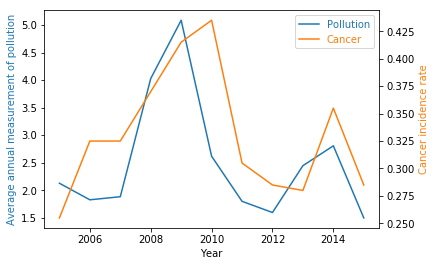

śląskie Ni(PM10) ICD=C31 PCC=0.686 -1.89814719016


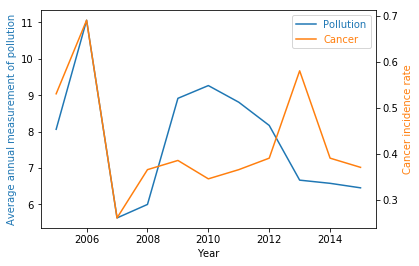

śląskie BaP(PM10) ICD=C48 PCC=0.516 -3.77975067698


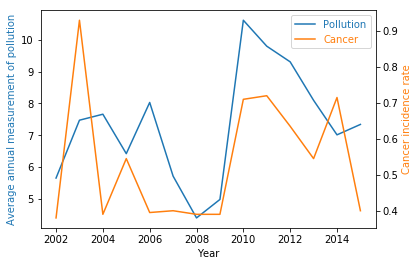

świętokrzyskie SO2 ICD=C11 PCC=0.559 7.35855653937


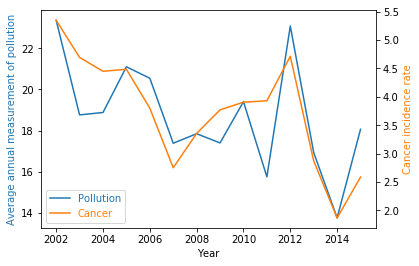

świętokrzyskie NO2 ICD=C23 PCC=0.791 -5.79773342425


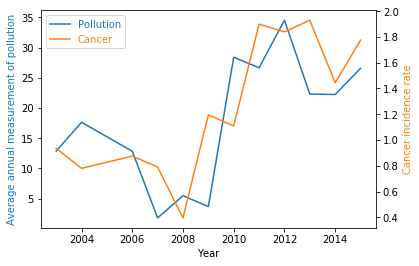

świętokrzyskie NOx ICD=C10 PCC=0.738 14.9726643602


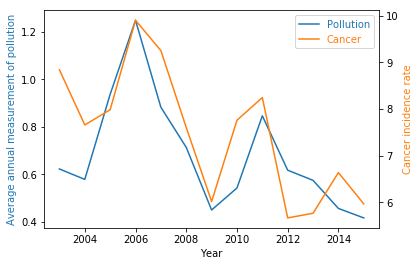

świętokrzyskie CO ICD=C53 PCC=0.776 -14.0507876132


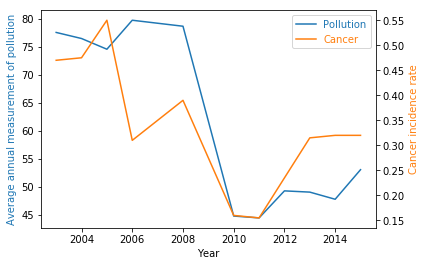

świętokrzyskie O3 ICD=C31 PCC=0.778 -16.5847628459


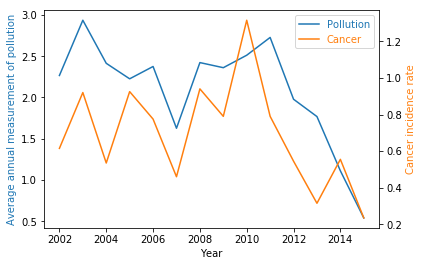

świętokrzyskie C6H6 ICD=C26 PCC=0.713 -11.77389696


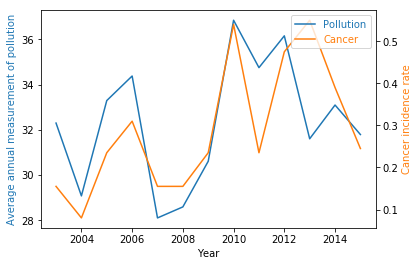

świętokrzyskie PM10 ICD=C06 PCC=0.674 9.12608898494


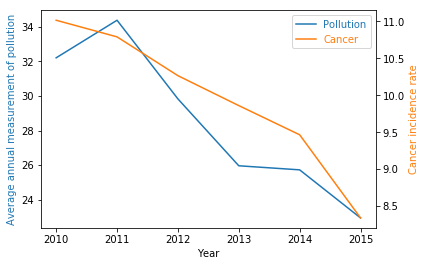

świętokrzyskie PM2,5 ICD=C25 PCC=0.930 -7.04323482218


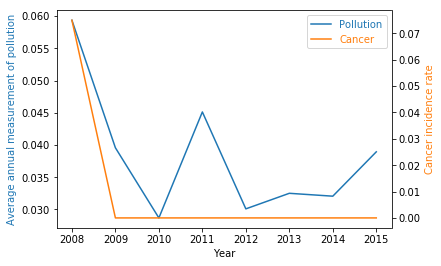

świętokrzyskie Pb(PM10) ICD=C58 PCC=0.837 -7.60046635872


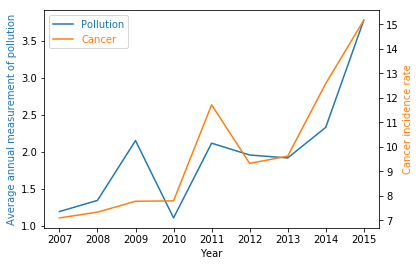

świętokrzyskie As(PM10) ICD=C73 PCC=0.892 13.3124652334


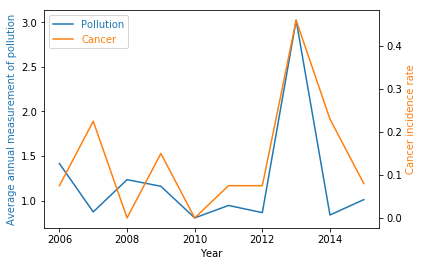

świętokrzyskie Cd(PM10) ICD=C52 PCC=0.734 -1.75356718064


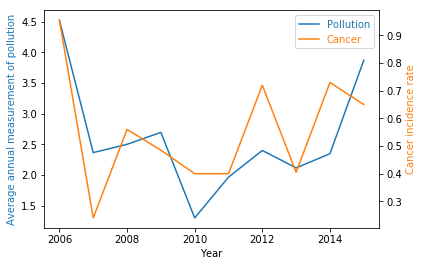

świętokrzyskie Ni(PM10) ICD=C60 PCC=0.707 -4.26290405684


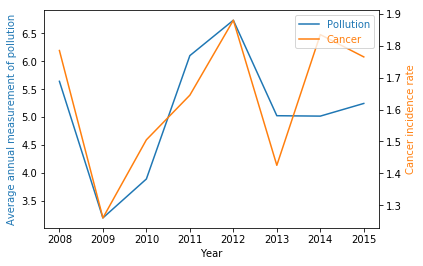

świętokrzyskie BaP(PM10) ICD=C49 PCC=0.784 1.39705813566


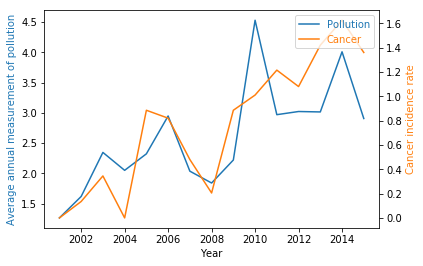

warmińsko-mazurskie SO2 ICD=D05 PCC=0.781 24.3413913796


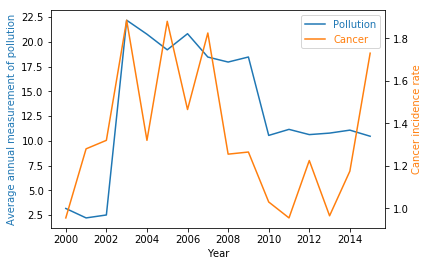

warmińsko-mazurskie NO2 ICD=C49 PCC=0.534 0.83469767083


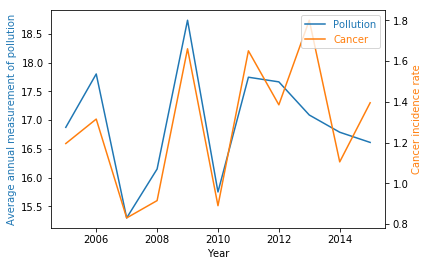

warmińsko-mazurskie NOx ICD=C24 PCC=0.796 3.51892723651


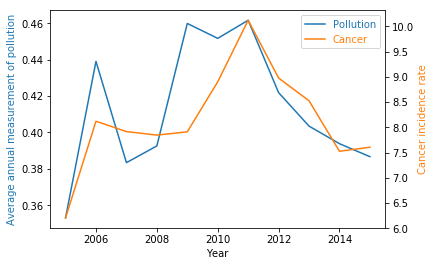

warmińsko-mazurskie CO ICD=C56 PCC=0.763 -4.41217685843


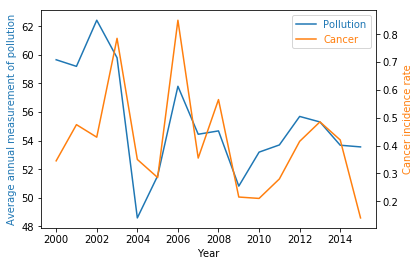

warmińsko-mazurskie O3 ICD=C14 PCC=0.530 -18.7893761457


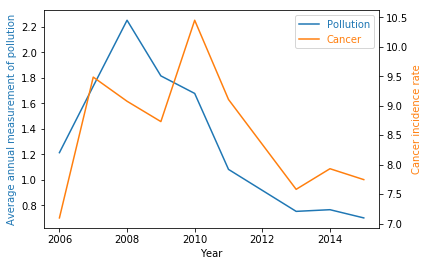

warmińsko-mazurskie C6H6 ICD=C53 PCC=0.639 -31.0304217692


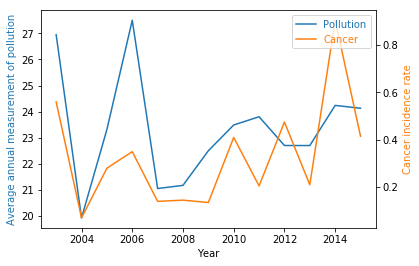

warmińsko-mazurskie PM10 ICD=C74 PCC=0.565 0.166841898081


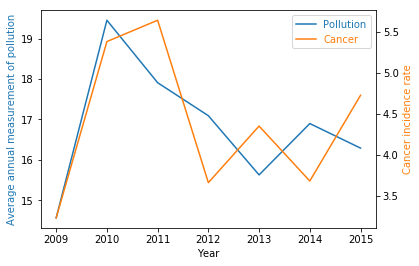

warmińsko-mazurskie PM2,5 ICD=C22 PCC=0.714 -16.1150698667


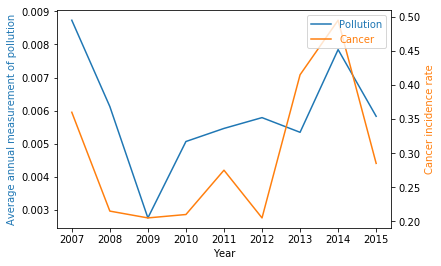

warmińsko-mazurskie Pb(PM10) ICD=C11 PCC=0.603 -6.15325725675


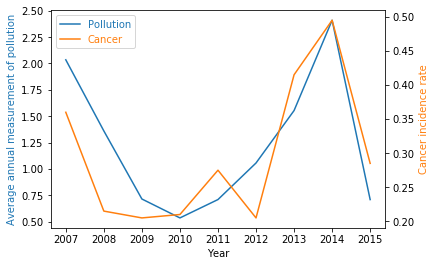

warmińsko-mazurskie As(PM10) ICD=C11 PCC=0.815 -3.98765216576


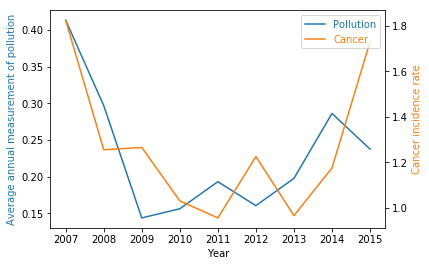

warmińsko-mazurskie Cd(PM10) ICD=C49 PCC=0.647 -12.565758872


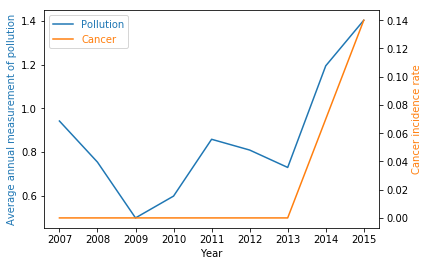

warmińsko-mazurskie Ni(PM10) ICD=D09 PCC=0.876 26.4061283549


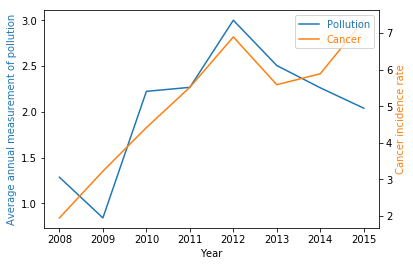

warmińsko-mazurskie BaP(PM10) ICD=C80 PCC=0.770 11.939878306


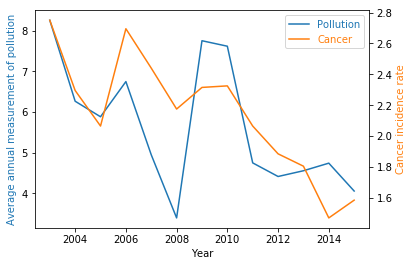

wielkopolskie SO2 ICD=C85 PCC=0.683 -19.8247526845


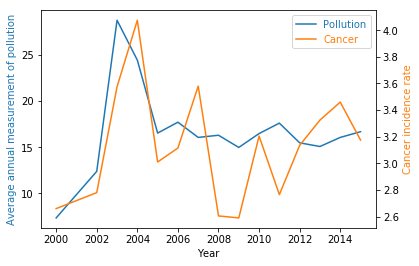

wielkopolskie NO2 ICD=C92 PCC=0.654 -4.36153989669


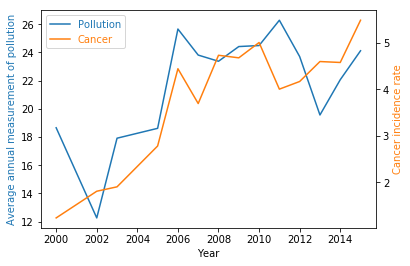

wielkopolskie NOx ICD=C83 PCC=0.759 17.9924995143


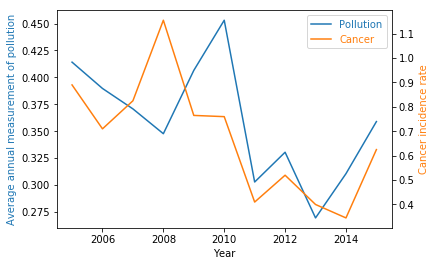

wielkopolskie CO ICD=C26 PCC=0.612 -15.4315602091


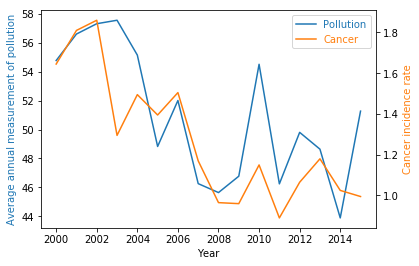

wielkopolskie O3 ICD=C00 PCC=0.760 -19.9179039102


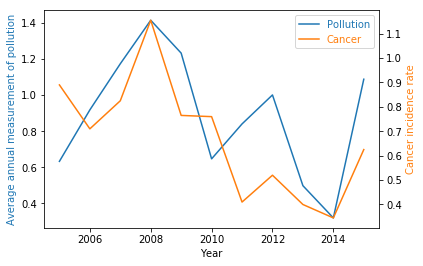

wielkopolskie C6H6 ICD=C26 PCC=0.648 -8.81199977335


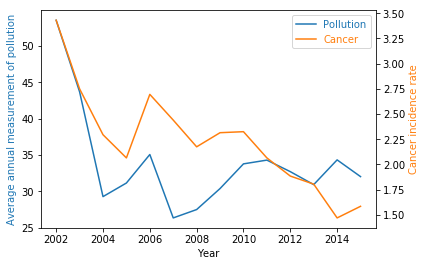

wielkopolskie PM10 ICD=C85 PCC=0.657 -14.7206339536


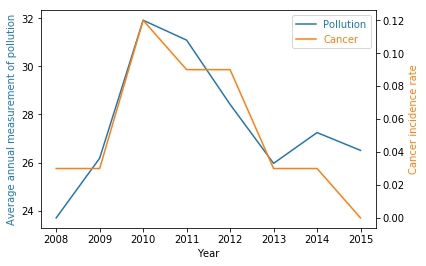

wielkopolskie PM2,5 ICD=C63 PCC=0.843 0.997903001745


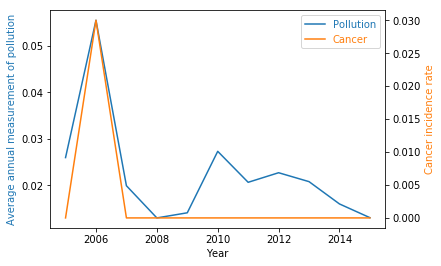

wielkopolskie Pb(PM10) ICD=C97 PCC=0.912 -12.2906155756


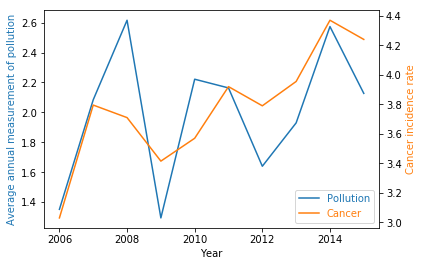

wielkopolskie As(PM10) ICD=C15 PCC=0.667 9.23681144663


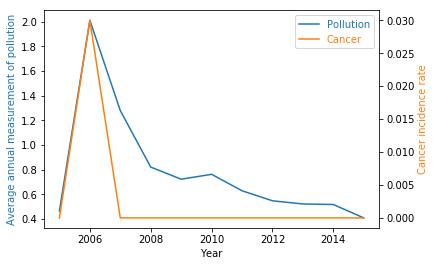

wielkopolskie Cd(PM10) ICD=C97 PCC=0.860 -15.3681521935


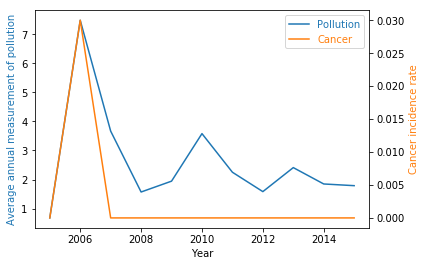

wielkopolskie Ni(PM10) ICD=C97 PCC=0.881 -7.86975782907


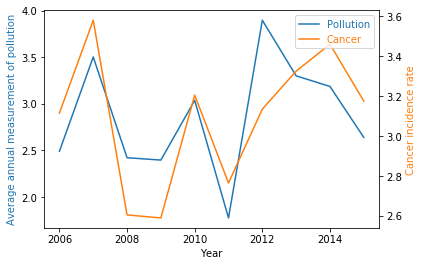

wielkopolskie BaP(PM10) ICD=C92 PCC=0.710 7.28617182866


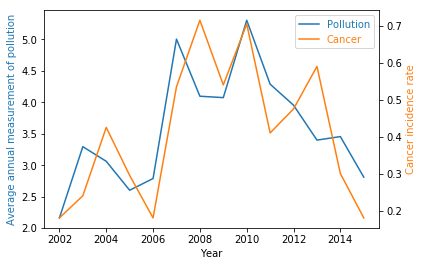

zachodniopomorskie SO2 ICD=C14 PCC=0.786 -8.02036889707


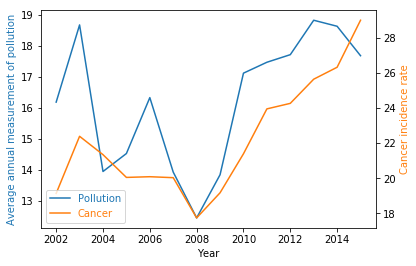

zachodniopomorskie NO2 ICD=C18 PCC=0.766 19.0478886285


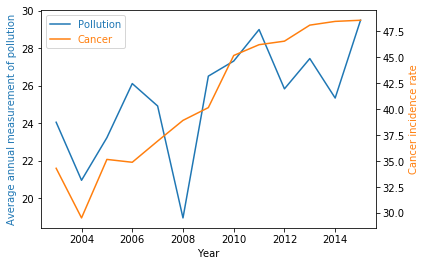

zachodniopomorskie NOx ICD=C50 PCC=0.671 10.8623178861


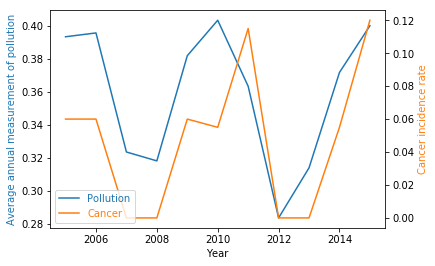

zachodniopomorskie CO ICD=C39 PCC=0.771 1.41211560218


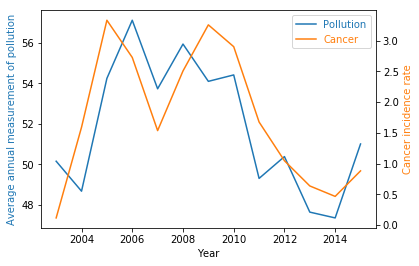

zachodniopomorskie O3 ICD=C76 PCC=0.788 -24.2338482278


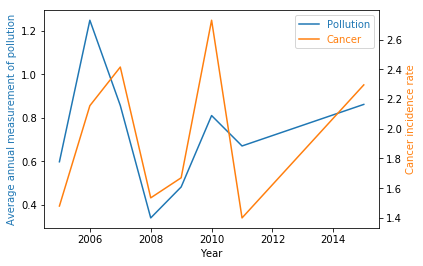

zachodniopomorskie C6H6 ICD=C49 PCC=0.613 1.03158255357


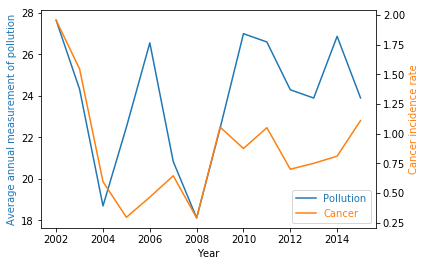

zachodniopomorskie PM10 ICD=C82 PCC=0.522 4.94395395158


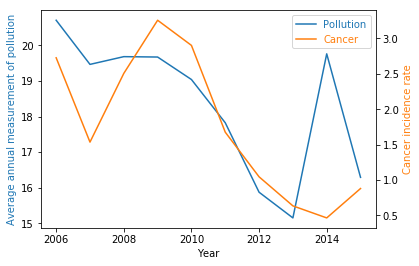

zachodniopomorskie PM2,5 ICD=C76 PCC=0.631 -21.9918871213


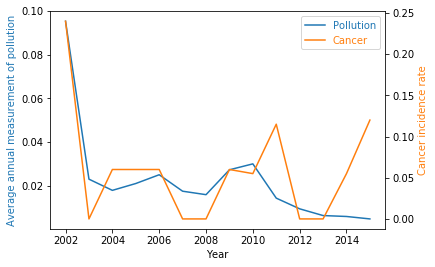

zachodniopomorskie Pb(PM10) ICD=C39 PCC=0.726 -9.04332037629


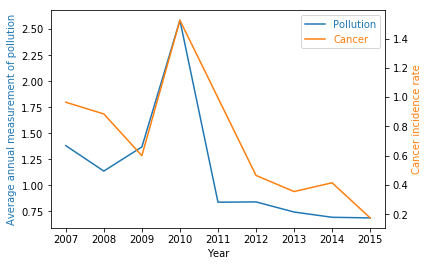

zachodniopomorskie As(PM10) ICD=C40 PCC=0.842 -17.2775642007


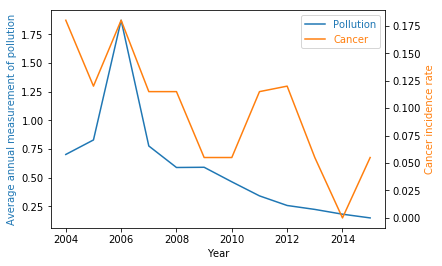

zachodniopomorskie Cd(PM10) ICD=C33 PCC=0.683 -24.4382881437


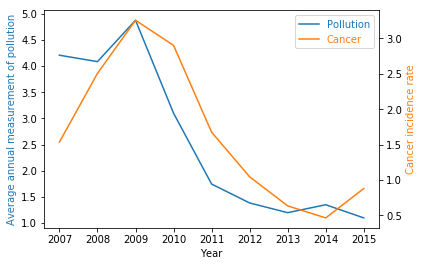

zachodniopomorskie Ni(PM10) ICD=C76 PCC=0.826 -28.4891694827


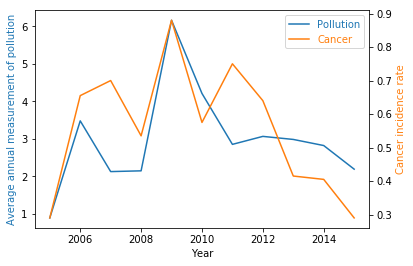

zachodniopomorskie BaP(PM10) ICD=C26 PCC=0.684 -4.45585581803


In [4]:
# Results for all provinces and all gases
gazy=['SO2','NO2','NOx','CO','O3','C6H6','PM10','PM2,5','Pb(PM10)','As(PM10)','Cd(PM10)','Ni(PM10)','BaP(PM10)']
for woj in range(1,17):
    df=wczytaj_statystyke_nowotworow(woj)
    for gaz in gazy:
        wczytaj_zanieczyszczenia(woj,gaz,110,True)

C:\Users\Python\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Python\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


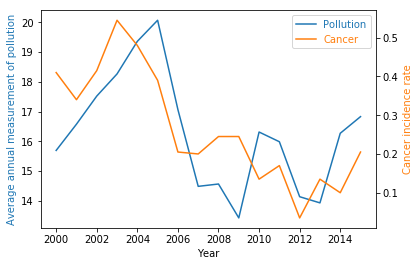

dolnośląskie NO2 ICD=C96 PCC=0.654 -16.1284241121


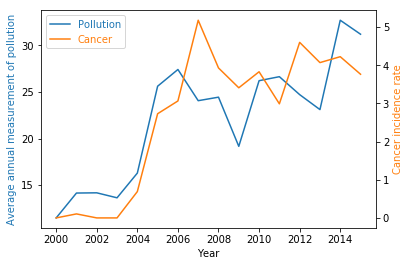

dolnośląskie NOx ICD=C83 PCC=0.833 22.8010571579


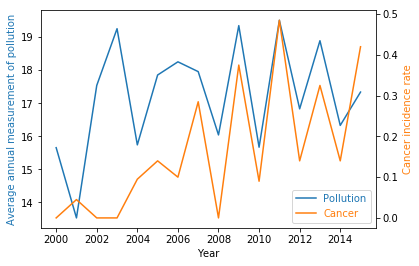

kujawsko-pomorskie NO2 ICD=D07 PCC=0.554 10.7799671166


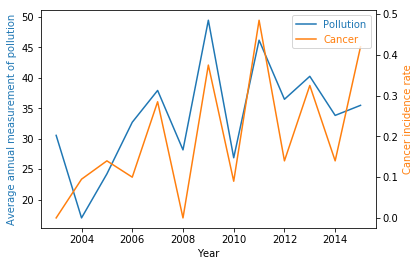

kujawsko-pomorskie NOx ICD=D07 PCC=0.746 24.5651668925


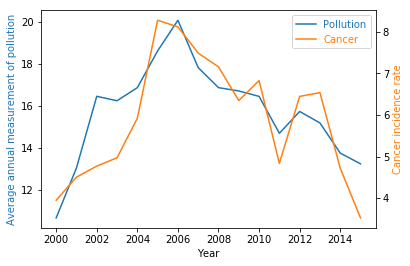

lubelskie NO2 ICD=C91 PCC=0.853 6.4483297022


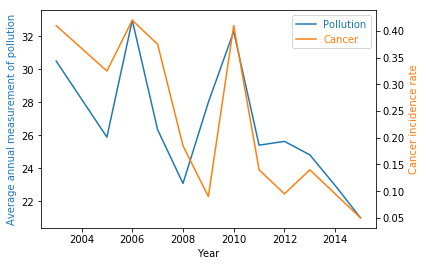

lubelskie NOx ICD=C95 PCC=0.778 -8.51564780517


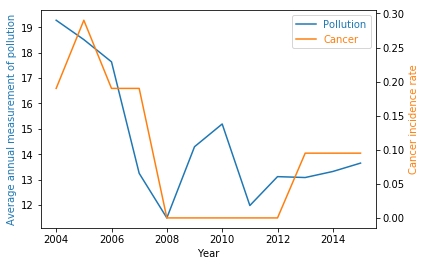

lubuskie NO2 ICD=C57 PCC=0.718 -27.3733753167


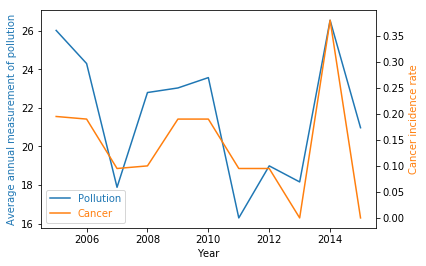

lubuskie NOx ICD=D07 PCC=0.750 -4.2456971593


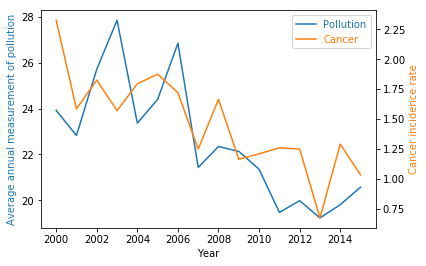

łódzkie NO2 ICD=C00 PCC=0.682 -32.6946666817


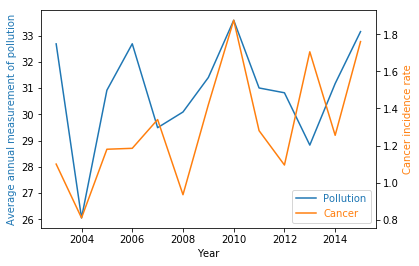

łódzkie NOx ICD=C51 PCC=0.499 7.06926876811


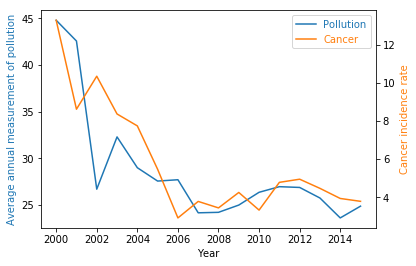

małopolskie NO2 ICD=C80 PCC=0.786 -9.77076077542


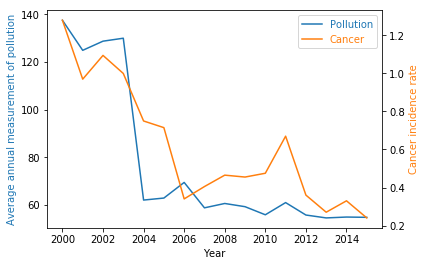

małopolskie NOx ICD=C38 PCC=0.898 -8.03698435709


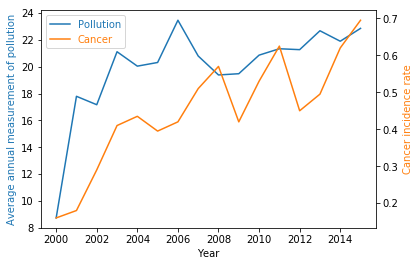

mazowieckie NO2 ICD=C17 PCC=0.724 12.9285389515


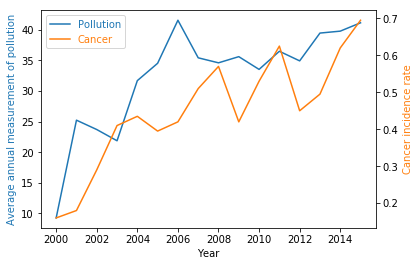

mazowieckie NOx ICD=C17 PCC=0.781 12.556233479


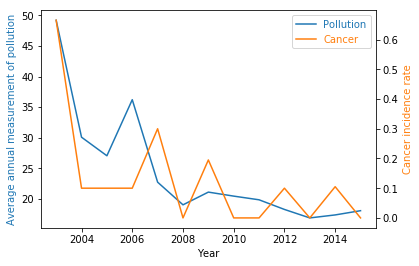

opolskie NO2 ICD=C14 PCC=0.777 -19.2228911178


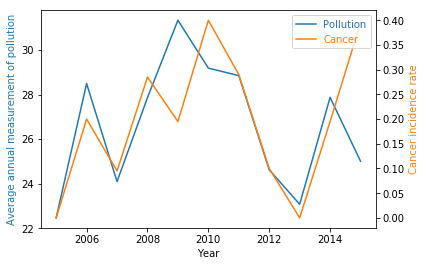

opolskie NOx ICD=C26 PCC=0.617 2.42339519474


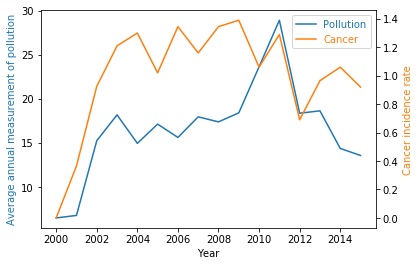

podkarpackie NO2 ICD=D06 PCC=0.674 8.81545344542


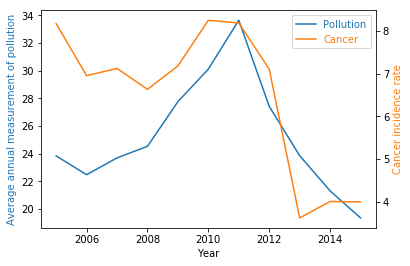

podkarpackie NOx ICD=C80 PCC=0.685 -19.9182878456


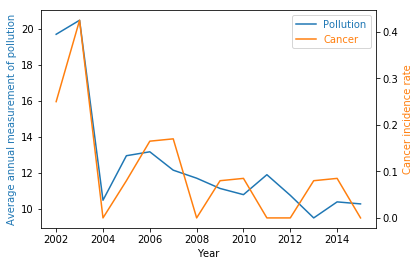

podlaskie NO2 ICD=C33 PCC=0.865 -2.21351952873


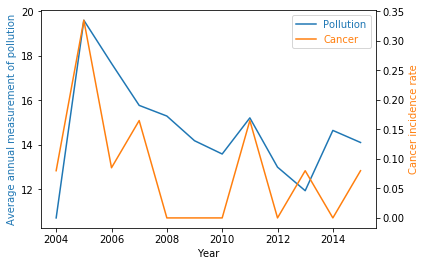

podlaskie NOx ICD=C88 PCC=0.614 -3.53555667006


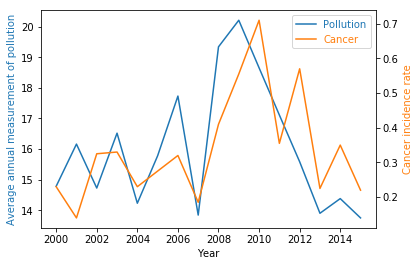

pomorskie NO2 ICD=C31 PCC=0.659 -7.05715731605


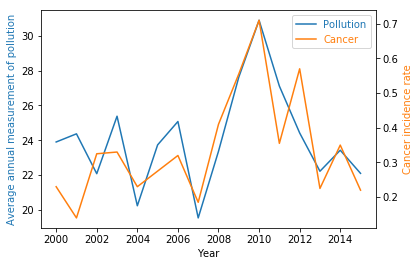

pomorskie NOx ICD=C31 PCC=0.748 2.57548888799


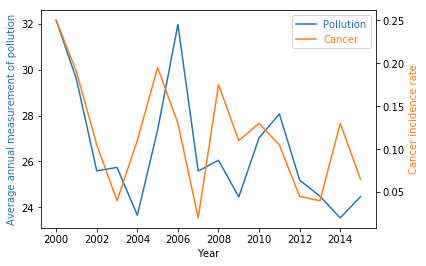

śląskie NO2 ICD=C33 PCC=0.611 -12.2600530022


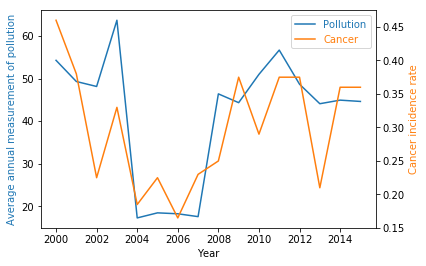

śląskie NOx ICD=C57 PCC=0.699 11.6075513611


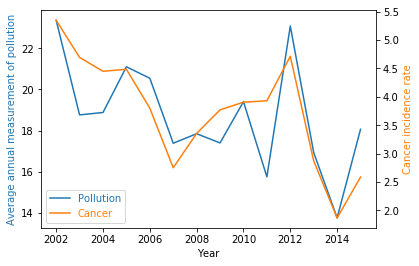

świętokrzyskie NO2 ICD=C23 PCC=0.791 -5.79773342425


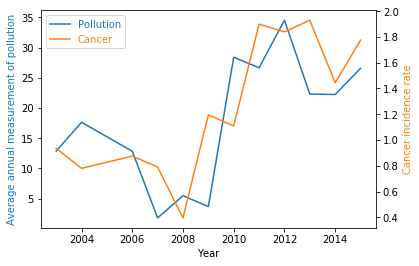

świętokrzyskie NOx ICD=C10 PCC=0.738 14.9726643602


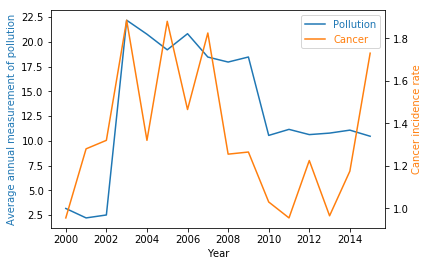

warmińsko-mazurskie NO2 ICD=C49 PCC=0.534 0.83469767083


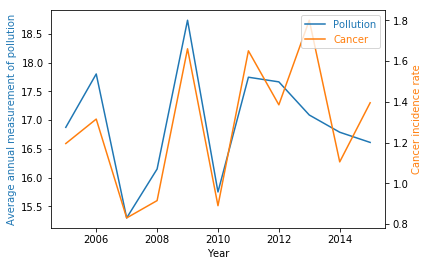

warmińsko-mazurskie NOx ICD=C24 PCC=0.796 3.51892723651


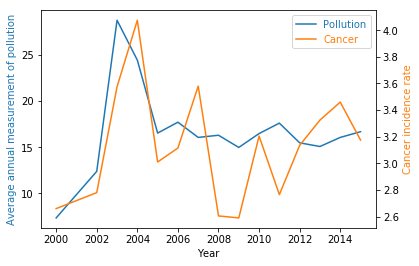

wielkopolskie NO2 ICD=C92 PCC=0.654 -4.36153989669


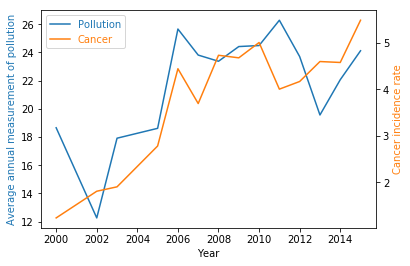

wielkopolskie NOx ICD=C83 PCC=0.759 17.9924995143


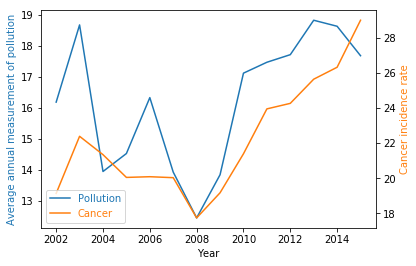

zachodniopomorskie NO2 ICD=C18 PCC=0.766 19.0478886285


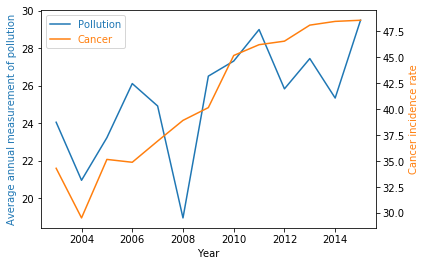

zachodniopomorskie NOx ICD=C50 PCC=0.671 10.8623178861


In [5]:
# Results for two gases and all provinces
gazy=['NO2','NOx']
for woj in range(1,17):
    df=wczytaj_statystyke_nowotworow(woj)
    for gaz in gazy:
        wczytaj_zanieczyszczenia(woj,gaz,110,True)

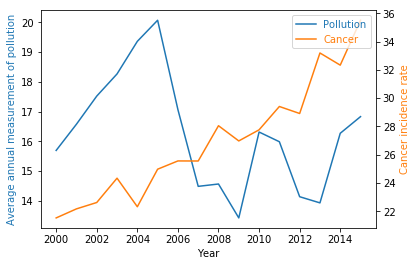

dolnośląskie NO2 ICD=C18 PCC=-0.384 -0.384051360249


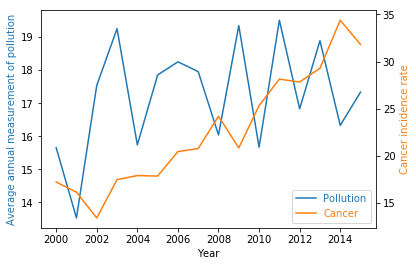

kujawsko-pomorskie NO2 ICD=C18 PCC=0.141 0.140918362087


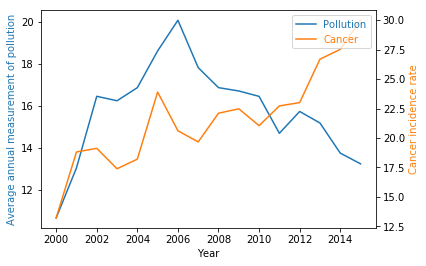

lubelskie NO2 ICD=C18 PCC=0.034 0.0336650136602


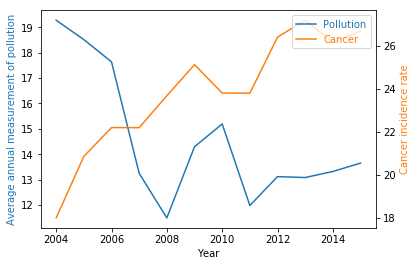

lubuskie NO2 ICD=C18 PCC=-0.732 -0.73172363729


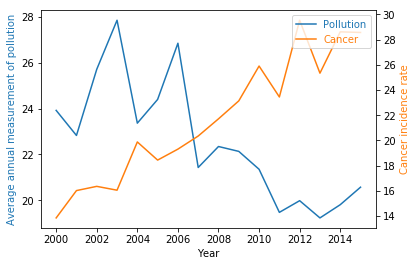

łódzkie NO2 ICD=C18 PCC=-0.773 -0.772571718292


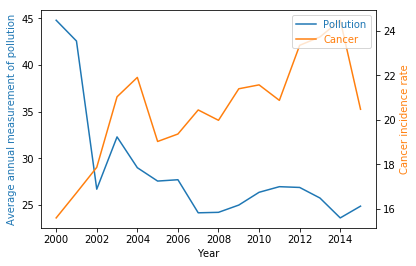

małopolskie NO2 ICD=C18 PCC=-0.704 -0.704378112858


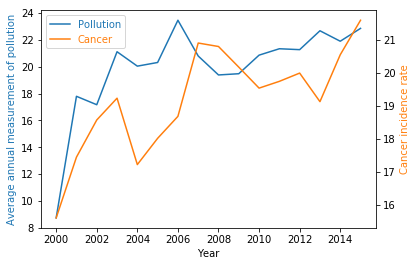

mazowieckie NO2 ICD=C18 PCC=0.679 0.679329820206


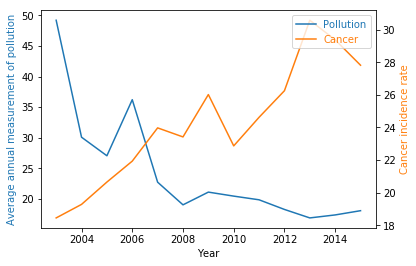

opolskie NO2 ICD=C18 PCC=-0.776 -0.775845735796


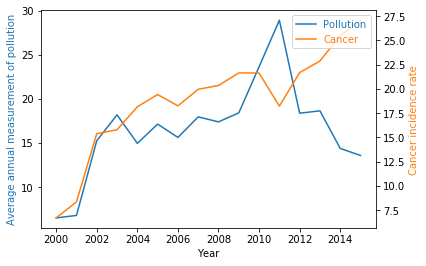

podkarpackie NO2 ICD=C18 PCC=0.508 0.507516020281


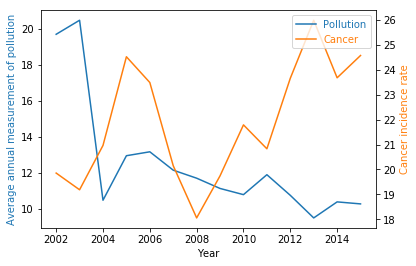

podlaskie NO2 ICD=C18 PCC=-0.472 -0.471813776616


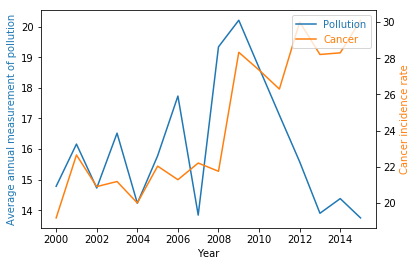

pomorskie NO2 ICD=C18 PCC=0.040 0.0396843613573


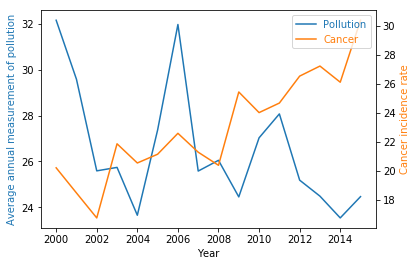

śląskie NO2 ICD=C18 PCC=-0.391 -0.391477342866


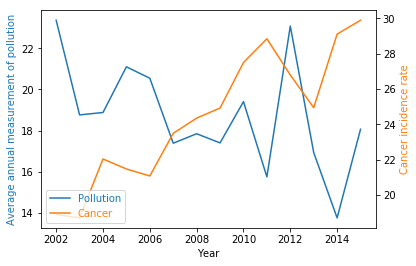

świętokrzyskie NO2 ICD=C18 PCC=-0.529 -0.528839244235


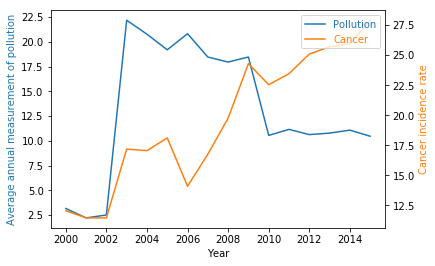

warmińsko-mazurskie NO2 ICD=C18 PCC=0.160 0.159949130749


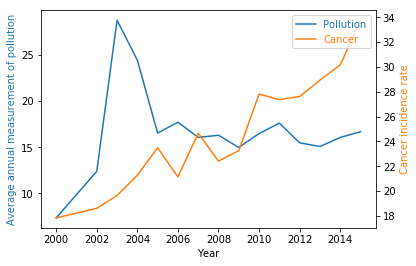

wielkopolskie NO2 ICD=C18 PCC=-0.029 -0.0293640643663


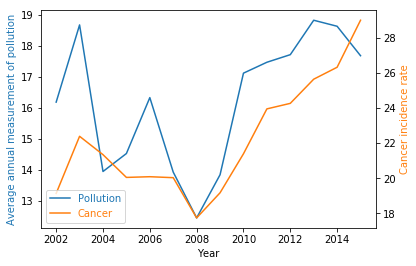

zachodniopomorskie NO2 ICD=C18 PCC=0.766 0.765507864609


In [6]:
# Results for one gas and one cancer
for woj in range(1,17):
    df=wczytaj_statystyke_nowotworow(woj)
    wczytaj_zanieczyszczenia(woj,'NO2',18,True)

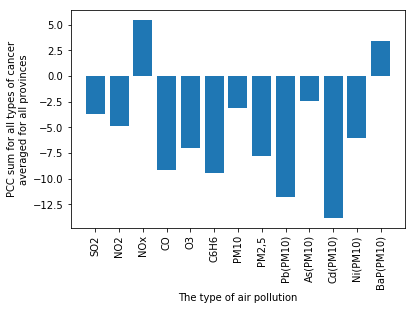

In [29]:
# Average sum of PCC for all provinces and all gases
gazy=['SO2','NO2','NOx','CO','O3','C6H6','PM10','PM2,5','Pb(PM10)','As(PM10)','Cd(PM10)','Ni(PM10)','BaP(PM10)']
x=np.arange(13)
kore=[-3.662037564,
      -4.876577854,
      5.418274806,
      -9.163319023,
      -6.996582891,
      -9.473832417,
      -3.103150254,
      -7.823036477,
      -11.74975275,
      -2.425716732,
      -13.81878331,
      -6.007786025,
      3.356450039]
plt.bar(x,kore)
plt.xticks(x,gazy,rotation=90)
plt.xlabel('The type of air pollution')
plt.ylabel('PCC sum for all types of cancer\naveraged for all provinces')
plt.show()

In the second part of the analysis, it was checked which contaminants have the greatest impact on cancer formation of small intestine (C17) and large intestine (C18).<br>
The Random Forest Regressor model was used.<br>
Random forests is an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.

In [9]:
# Part 2 of the analysis (regression model)
def przygotuj_dane(rak):

    df3=pd.DataFrame()

    for woj in range(1,17):
        
        df=wczytaj_statystyke_nowotworow(woj)

        df1=pd.DataFrame()
        gazy=['SO2','NO2','NOx','CO','O3','C6H6','PM10','PM2,5','Pb(PM10)','As(PM10)','Cd(PM10)','Ni(PM10)','BaP(PM10)']
        for gaz in gazy:
            df1=pd.concat([df1,wczytaj_zanieczyszczenia(woj,gaz,110,False)],axis=1)
        df1.columns=gazy

        df2=df[df.index==rak]
        df2=df2.T[1:]
        df2.columns=['Rak']
    
        df3=df3.append(pd.concat([df1,df2],axis=1))
        
        print(str(round(woj*6.25))+'%')
        
    return df3

In [10]:
df17=przygotuj_dane(17)
df18=przygotuj_dane(18)
df34=przygotuj_dane(34)

6%
12%
19%
25%
31%
38%
44%
50%
56%
62%
69%
75%
81%
88%
94%
100%
6%
12%
19%
25%
31%
38%
44%
50%
56%
62%
69%
75%
81%
88%
94%
100%
6%
12%
19%
25%
31%
38%
44%
50%
56%
62%
69%
75%
81%
88%
94%
100%


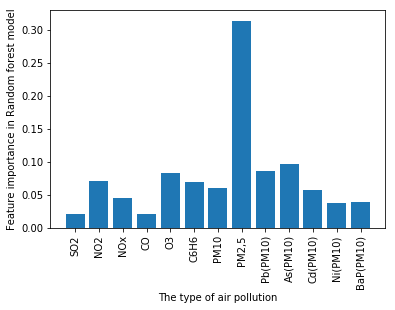

{'max_depth': 9, 'max_leaf_nodes': 24} -0.192313069359


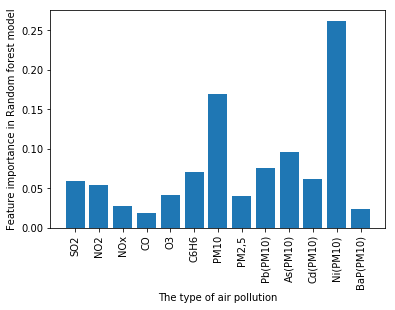

{'max_depth': 5, 'max_leaf_nodes': None} -0.103174364522


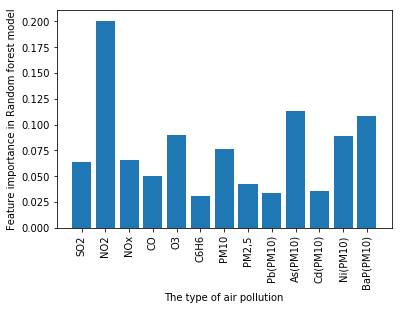

{'max_depth': 5, 'max_leaf_nodes': 12} -0.386447290596


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

gazy=['SO2','NO2','NOx','CO','O3','C6H6','PM10','PM2,5','Pb(PM10)','As(PM10)','Cd(PM10)','Ni(PM10)','BaP(PM10)']
x=np.arange(13)
for df in [df34,df17,df18]:
    data=df.dropna()

    X=data.iloc[:,:-1]
    y=data.iloc[:,-1]
    
    parameters={'max_depth':np.arange(5,20),
                'max_leaf_nodes':list(np.arange(10,25))+[None]}
    regr=RandomForestRegressor(n_estimators=50,random_state=0)
    clf=GridSearchCV(regr,parameters)
    clf.fit(X,y)
    
    plt.bar(x,clf.best_estimator_.feature_importances_)
    plt.xticks(x,gazy,rotation=90)
    plt.xlabel('The type of air pollution')
    plt.ylabel('Feature importance in Random forest model')
    plt.show()
    
    print(clf.best_params_,clf.best_score_)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

score=np.empty(1000)
for i in range(1000):
    X_train,X_test,y_train,y_test=train_test_split(X,y)
    regr=RandomForestRegressor(max_depth=5,max_leaf_nodes=12,n_estimators=50)
    regr.fit(X_train,y_train)
    score[i]=regr.score(X_test,y_test)
print(score.mean(),score.max())

0.206692885918 0.535850149297


**Conclusions**<br>
1. Nitrogen oxides have been shown to be the best correlated type of gas with cancer statistics.
2. Nitrogen oxides are among the most dangerous compounds polluting the atmosphere. They are several times more harmful than sulfur dioxide and almost ten times more than carbon monoxide. We have enough in Poland. Especially in big cities, because one of the main sources of their emission is road transport.
3. The group of nitrogen oxides consists essentially of six chemical compounds composed of oxygen and nitrogen atoms. From the point of view of the formation of smog, only two are important: nitric oxide (NO) and nitrogen dioxide (NO2). The remaining ones do not occur in the free state or do not have toxic properties.
4. The effects of prolonged exposure to excessive NO2 concentrations are more bleak. Although it is difficult to isolate the effects of the health effects of only nitrogen dioxide alone, because it occurs in smog with other toxic substances, there are scientific grounds to attribute to it the impact on the development of serious illnesses, such as:
 - bronchial asthma,
 - chronic obstructive pulmonary disease,
 - cardiovascular disease
 - and tumors, in particular the lungs and breasts.
5. In Poland alone, the number of deaths attributed to long-term exposure to NO2 is estimated at 1.6 thousand annually. It is worth mentioning that nitrogen oxides also harm us indirectly. They are precursors of carcinogenic compounds formed in soils that can penetrate into food. In this case, their impact on the incidence of chronic diseases and, as a consequence, mortality is very difficult to estimate.
6. Below there are exact results of correlation in given voivodships with the type of cancer:
 - dolnośląskie:<br>
NO2 ICD=C56 PCC=0.46 / NOx ICD=C83 PCC=0.83<br>
 - kujawsko-pomorskie:<br>
NO2 ICD=C91 PCC=0.49 / NOx ICD=C50 PCC=0.69<br>
 - lubelskie:<br>
NO2 ICD=C91 PCC=0.85 / NOx ICD=C22 PCC=0.62<br>
 - lubuskie:<br>
NO2 ICD=C80 PCC=0.61 / NOx ICD=C32 PCC=0.47<br>
 - łódzkie:<br>
NO2 ICD=C53 PCC=0.29 / NOx ICD=C56 PCC=0.49<br>
 - małopolskie:<br>
NO2 ICD=C80 PCC=0.79 / NOx ICD=C80 PCC=0.88<br>
 - mazowieckie:<br>
NO2 ICD=C18 PCC=0.68 / NOx ICD=C61 PCC=0.77<br>
 - opolskie:<br>
NO2 ICD=C32 PCC=0.57 / NOx ICD=C20 PCC=0.33<br>
 - podkarpackie:<br>
NO2 ICD=C20 PCC=0.64 / NOx ICD=C80 PCC=0.68<br>
 - podlaskie:<br>
NO2 ICD=C53 PCC=0.63 / NOx ICD=C53 PCC=0.33<br>
 - pomorskie:<br>
NO2 ICD=C67 PCC=0.21 / NOx ICD=C20 PCC=0.35<br>
 - śląskie:<br>
NO2 ICD=C22 PCC=0.51 / NOx ICD=C25 PCC=0.62<br>
 - świętokrzyskie:<br>
NO2 ICD=C23 PCC=0.79 / NOx ICD=C54 PCC=0.71<br>
 - warmińsko-mazurskie:<br>
NO2 ICD=C32 PCC=0.33 / NOx ICD=C20 PCC=0.38<br>
 - wielkopolskie:<br>
NO2 ICD=C56 PCC=0.23 / NOx ICD=C83 PCC=0.76<br>
 - zachodniopomorskie:<br>
NO2 ICD=C18 PCC=0.77 / NOx ICD=C50 PCC=0.67<br>
7. Based on the above analysis, it was found that the formation of C17 and C18 disease (colorectal cancer) is the most correlated with the emission of nitrogen oxides in the Masovia Province and in the West Pomeranian Voivodeship also.
8. Analysis of the influence of the type of air pollutants on the formation of colorectal cancer showed that the most important issue is the emission of nitrogen dioxide.
9. Emissions of nitrogen oxides as well as arsenic and benzoalfapiren compounds found in suspended dust have an impact on the development of intestinal diseases (mainly C18).
10. Due to the non-uniform location of measurement stations (http://powietrze.gios.gov.pl/pjp/maps/measuringstation), more accurate measurements of hazardous substances should be carried out using a swarm of drones.

**Literature**<br>
1. Wojciechowska U., Didkowska J., Illnesses and deaths from malignant tumors in Poland. National Cancer Registry, Oncology Center - Instytut im. Maria Skłodowska-Curie. Available at http://onkologia.org.pl/raporty/ (access: August 2018)
2. Statistics data from Chief Inspectorate for Environmental Protection. Measurement data bank. Available at http://powietrze.gios.gov.pl/pjp/archives/downloadFile/244 (access: August 2018)
3. https://en.wikipedia.org/wiki/Base64
4. https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
5. https://en.wikipedia.org/wiki/Random_forest
6. https://smoglab.pl/co-i-jak-nas-truje-tlenki-azotu-1/
7. Gagolewski M., Bartoszuk M., Cena A., Data Processing and Analysis in Python. PWN, Warsaw 2016 

In [17]:
import xgboost as xgb
for i in range(1000):
    X_train,X_test,y_train,y_test=train_test_split(X,y)
    bst=xgb.XGBRegressor(max_depth=5,n_estimators=50)
    bst.fit(X_train,y_train)
    score[i]=bst.score(X_test,y_test)
print(score.mean(),score.max())

0.0960552192082 0.534299886956


In [18]:
from sklearn import linear_model
for i in range(1000):
    X_train,X_test,y_train,y_test=train_test_split(X,y)
    clf=linear_model.Lasso(alpha=0.1)
    clf.fit(X_train,y_train)
    score[i]=clf.score(X_test,y_test)
print(score.mean(),score.max())

0.101352681833 0.488735626252


-0.2482468518910681

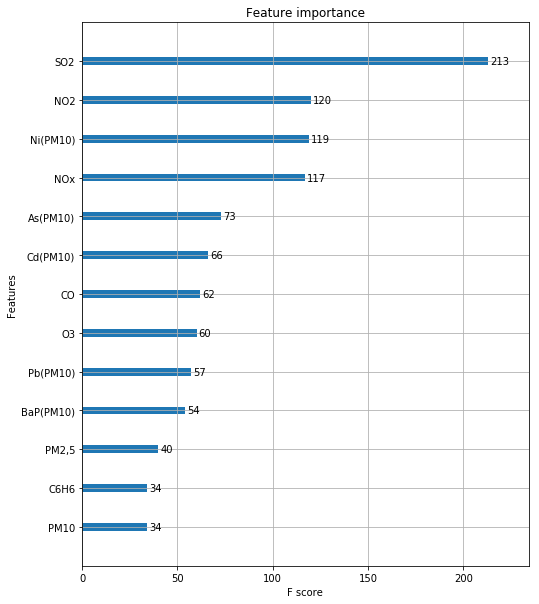

In [34]:
from sklearn.model_selection import cross_val_score
model=xgb.XGBRegressor(max_depth=5, n_estimators=80, learning_rate=0.1)
model.fit(X_train,y_train)
fit_params={'early_stopping_rounds': 30, 
            'eval_metric': 'mae',
            'verbose': False,
            'eval_set': [[X_train, y_train]]}
xgb_cv = cross_val_score(model, X_train, y_train, 
                         cv = 15, 
                         scoring = 'neg_mean_absolute_error',
                         fit_params = fit_params)
fig, ax = plt.subplots(figsize=(8, 10))
xgb.plot_importance(model, ax=ax)
model.score(X_test,y_test)